## Imports

In [1]:
import numpy as np
import pandas as pd
import nltk
import wget as wget
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import re

from utils import *

pd.set_option('display.max_rows', 250)

[nltk_data] Downloading package stopwords to /Users/dnb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/dnb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/dnb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
stoplist = stopwords.words('english')
stoplist.append("i'm")

In [3]:
print(stoplist)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Предобработка данных

Данные 'user_id', 'song_id', 'play_count' из файла 'data/train_triplets.txt' -> датафрейм df_echonest.

In [4]:
# df_echonest = pd.read_csv('data/train_triplets.txt', sep='\t', header=None)
# df_echonest.columns = ['user_id', 'song_id', 'play_count']
# df_echonest.head()

In [5]:
# df_echonest.to_csv('data/df_echonest.csv', index=False)

In [4]:
df_echonest = pd.read_csv('data/df_echonest.csv')
df_echonest.head()

,user_id,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


In [7]:
df_echonest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48373586 entries, 0 to 48373585
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   user_id     object
 1   song_id     object
 2   play_count  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ GB


In [8]:
df_echonest['play_count'].value_counts()

1      28755966
2       7336825
3       3214271
5       2250999
4       1805081
         ...   
396           1
995           1
385           1
600           1
771           1
Name: play_count, Length: 720, dtype: int64

Обработка файла с текстами песен. Данные 'track_id', 'mxm_track_id', 'text' из файла 'data/mxm_dataset_train.txt' -> датафрейм df_mxm_text_songs. Из 'text' удаляются стоп-слова

In [9]:
# df_mxm_text_songs = get_mxm_text_songs('data/mxm_dataset_train.txt', stopwords)
# df_mxm_text_songs.head()

In [10]:
# df_mxm_text_songs.to_csv('data/mxm_text_songs.csv', index=False)
df_mxm_text_songs = pd.read_csv('data/mxm_text_songs.csv')
df_mxm_text_songs.head()

,track_id,mxm_track_id,text
0,TRAAAAV128F421A322,4623710,like like de got would seem someon understand ...
1,TRAAABD128F429CF47,6477168,know know know know know time time time la la ...
2,TRAAAED128E0783FAB,2516445,love love love love love love love love love l...
3,TRAAAEF128F4273421,3759847,know got got got feel let would would would ey...
4,TRAAAEW128F42930C0,3783760,like take would wo someth stay burn burn burn ...


Обработка файла с жанрами песен. Данные 'track_id', 'majority_genre','minority_genre' из файла ->
	датафрейм df_tag_genre_songs. Отсутствующие значения заменяются на Nan.

In [11]:
# df_tag_genre_songs = get_tag_genre_songs('data/p02_msd_tagtraum_cd2.cls')
# df_tag_genre_songs.head()

In [12]:
# df_tag_genre_songs.to_csv('data/df_tag_genre_songs.csv', index=False)

In [13]:
df_tag_genre_songs = pd.read_csv('data/df_tag_genre_songs.csv')
df_tag_genre_songs.head()

,track_id,majority_genre,minority_genre
0,TRAAAAK128F9318786,Rock,NaN
1,TRAAAAW128F429D538,Rap,NaN
2,TRAAABD128F429CF47,Rock,RnB
3,TRAAADJ128F4287B47,Rock,NaN
4,TRAAADZ128F9348C2E,Latin,NaN


Обработка файла с названиями песен. Данные 'track_id', 'song_id', 'artist','title' из файла -> датафрейм df_tag_artist_title. Отсутствующие значения заменяются на Nan.

In [14]:
# df_tag_artist_title = get_tag_artist_title('data/p02_unique_tracks.txt')
# df_tag_artist_title.head()

In [15]:
df_tag_artist_title = pd.read_csv('data/df_tag_artist_title.csv')
df_tag_artist_title.head()

,track_id,song_id,artist,title
0,TRMMMTK128F424EF7C,SOIMMJJ12AF72AD643,Emery,Rock-N-Rule
1,TRMMMHQ128F4278194,SOVMBTP12A8C13A8F6,Los Ronaldos,La bola extra
2,TRMMMQV12903CA201E,SOOUESZ12AB0189AFD,Rev. Timothy Wright,I Made It Over
3,TRMMMMV128F14746A5,SOAGMGG12A6D4F9099,Pierre-Laurent Aimard,Debussy : 12 Etudes : VI Pour les huit doigts
4,TRMMMPN128F426610E,SOGFWVT12A8C137C64,Nicolette,Nervous


Добавляем столбец 'title_pure' с очищенными названиями песен (удалены скобки и содержимое, знаки препинания (кроме апострофа), лишние пробелы. Также названия приведены к нижнему регистру и удалены стоп-слова.

In [16]:
import re

df_tag_artist_title['title_pure'] = df_tag_artist_title.apply(lambda x: re.sub(r'[\(\[].*?[\)\]]', '', str(x['title'])), axis=1)

df_tag_artist_title['title_pure'] = df_tag_artist_title.apply(lambda x: re.sub(r'[^\'a-zA-Z ]', '', str(x['title'])), axis=1)

df_tag_artist_title['title_pure'] = df_tag_artist_title.apply(lambda x: re.sub(r'\s+', ' ', str(x['title_pure'])), axis=1)

df_tag_artist_title['title_pure'] = df_tag_artist_title['title_pure'].apply(title_without_stopwords, args=[stoplist])

df_tag_artist_title.head(10)

,track_id,song_id,artist,title,title_pure
0,TRMMMTK128F424EF7C,SOIMMJJ12AF72AD643,Emery,Rock-N-Rule,rocknrule
1,TRMMMHQ128F4278194,SOVMBTP12A8C13A8F6,Los Ronaldos,La bola extra,la bola extra
2,TRMMMQV12903CA201E,SOOUESZ12AB0189AFD,Rev. Timothy Wright,I Made It Over,made
3,TRMMMMV128F14746A5,SOAGMGG12A6D4F9099,Pierre-Laurent Aimard,Debussy : 12 Etudes : VI Pour les huit doigts,debussy etudes vi pour les huit doigts
4,TRMMMPN128F426610E,SOGFWVT12A8C137C64,Nicolette,Nervous,nervous
5,TRMMMNO128F93539AA,SOKLPMH12AB01861FA,Martin Sexton,In The Journey,journey
6,TRMMMTG128F426B5BB,SOEPAIN12A8C1396A7,Craze,Fuckin Ethic People (999),fuckin ethic people
7,TRMMMPJ128F9306985,SOQMZZI12AB01850D4,Christian Castro,Tu Vida Con La Mía,tu vida con la
8,TRMMMRZ128F4265EB4,SOEEHEY12CF5F88FB4,Aerosmith,I'm Ready,ready
9,TRMMMKD12903CF219E,SOWUMAZ12A67ADE769,Skinlab,Take As Needed,take needed


df_track - дф из df_tag_artist_title с добавленными текстами песен

In [17]:
df_track = pd.merge(df_tag_artist_title, df_mxm_text_songs, on='track_id', how='outer')
df_track.head()

,track_id,song_id,artist,title,title_pure,mxm_track_id,text
0,TRMMMTK128F424EF7C,SOIMMJJ12AF72AD643,Emery,Rock-N-Rule,rocknrule,9855482.0,time time go go go get see got never want want...
1,TRMMMHQ128F4278194,SOVMBTP12A8C13A8F6,Los Ronaldos,La bola extra,la bola extra,NaN,NaN
2,TRMMMQV12903CA201E,SOOUESZ12AB0189AFD,Rev. Timothy Wright,I Made It Over,made,610698.0,oh oh oh oh oh oh oh oh get get got got got go...
3,TRMMMMV128F14746A5,SOAGMGG12A6D4F9099,Pierre-Laurent Aimard,Debussy : 12 Etudes : VI Pour les huit doigts,debussy etudes vi pour les huit doigts,NaN,NaN
4,TRMMMPN128F426610E,SOGFWVT12A8C137C64,Nicolette,Nervous,nervous,NaN,NaN


In [18]:
# df_tag_artist_title.to_csv('data/df_tag_artist_title.csv', index=False)

Добавляем в df_track столбцы по значимым жанрам

In [19]:
df_track = pd.merge(df_track, df_tag_genre_songs, on='track_id', how='outer')
df_track.head()

,track_id,song_id,artist,title,title_pure,mxm_track_id,text,majority_genre,minority_genre
0,TRMMMTK128F424EF7C,SOIMMJJ12AF72AD643,Emery,Rock-N-Rule,rocknrule,9855482.0,time time go go go get see got never want want...,Rock,NaN
1,TRMMMHQ128F4278194,SOVMBTP12A8C13A8F6,Los Ronaldos,La bola extra,la bola extra,NaN,NaN,NaN,NaN
2,TRMMMQV12903CA201E,SOOUESZ12AB0189AFD,Rev. Timothy Wright,I Made It Over,made,610698.0,oh oh oh oh oh oh oh oh get get got got got go...,NaN,NaN
3,TRMMMMV128F14746A5,SOAGMGG12A6D4F9099,Pierre-Laurent Aimard,Debussy : 12 Etudes : VI Pour les huit doigts,debussy etudes vi pour les huit doigts,NaN,NaN,NaN,NaN
4,TRMMMPN128F426610E,SOGFWVT12A8C137C64,Nicolette,Nervous,nervous,NaN,NaN,NaN,NaN


In [20]:
df_track.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999988 entries, 0 to 999987
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   track_id        999988 non-null  object 
 1   song_id         999982 non-null  object 
 2   artist          999982 non-null  object 
 3   title           999967 non-null  object 
 4   title_pure      999982 non-null  object 
 5   mxm_track_id    210519 non-null  float64
 6   text            210503 non-null  object 
 7   majority_genre  280831 non-null  object 
 8   minority_genre  89430 non-null   object 
dtypes: float64(1), object(8)
memory usage: 76.3+ MB


## Top-250 tracks


		1. датафрейм со след. полями:
			1. номер индекса
			2. имя исполнителя
			3. название трека
			4. количество воспроизведений
		2. Таблица должна быть отсортирована по количеству воспроизведений по убыванию.

По заданию нам нужны 250 записей

In [5]:
df_1 = df_echonest.groupby(by='song_id').agg({'play_count': 'sum'}).sort_values(by='play_count', ascending=False)[:250].reset_index()
df_1.head()

,song_id,play_count
0,SOBONKR12A58A7A7E0,726885
1,SOAUWYT12A81C206F1,648239
2,SOSXLTC12AF72A7F54,527893
3,SOFRQTD12A81C233C0,425463
4,SOEGIYH12A6D4FC0E3,389880


Добавляем столбцы из df_track

In [29]:
df_1 = pd.merge(df_1, df_track.drop_duplicates(subset='song_id', keep='first'), on='song_id', how='inner')
df_1.head()

,song_id,play_count,track_id,artist,title,title_pure,mxm_track_id,text,majority_genre,minority_genre
0,SOBONKR12A58A7A7E0,726885,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One,one,1104550.0,love love know oh oh oh oh oh oh oh oh oh one ...,Country,NaN
1,SOAUWYT12A81C206F1,648239,TRGXQES128F42BA5EB,Björk,Undo,undo,1879235.0,oh oh oh oh way give tri tri tri cri hard hard...,Rock,Electronic
2,SOSXLTC12AF72A7F54,527893,TRONYHY128F92C9D11,Kings Of Leon,Revelry,revelry,NaN,NaN,Rock,NaN
3,SOFRQTD12A81C233C0,425463,TRDMBIJ128F4290431,Harmonia,Sehr kosmisch,sehr kosmisch,NaN,NaN,Rock,Metal
4,SOEGIYH12A6D4FC0E3,389880,TRLGMFJ128F4217DBE,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,horn concerto e flat k ii romance andante cant...,NaN,NaN,NaN,NaN


Оставляем требуемые по заданию

In [30]:
df_1 = df_1[['artist', 'title', 'play_count']]
df_1.head()

,artist,title,play_count
0,Dwight Yoakam,You're The One,726885
1,Björk,Undo,648239
2,Kings Of Leon,Revelry,527893
3,Harmonia,Sehr kosmisch,425463
4,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,389880


In [31]:
df_1.tail()

,artist,title,play_count
245,Triple Six Mafia,Now I'm High_ Really High,35253
246,The Red Jumpsuit Apparatus,Face Down (Album Version),35245
247,Linkin Park,New Divide (Album Version),35191
248,Selena Gomez & The Scene,Naturally,35074
249,Creedence Clearwater Revival,Have You Ever Seen The Rain,34831


## Top-100 tracks

		1. для заданного жанра на выходе датафрейм со след. полями:
			1. номер индекса
			2. имя исполнителя
			3. название трека
			4. количество воспроизведений
		2.  Таблица должна быть отсортирована по количеству воспроизведений по убыванию.
		3.  Использовать только основной жанр для выполнения подзадачи.

Сначала считываем дф с количеством воспроизведений

In [32]:
df_2 = df_echonest.groupby(by='song_id').agg({'play_count': 'sum'}).sort_values(by='play_count', ascending=False).reset_index()
df_2.head()

,song_id,play_count
0,SOBONKR12A58A7A7E0,726885
1,SOAUWYT12A81C206F1,648239
2,SOSXLTC12AF72A7F54,527893
3,SOFRQTD12A81C233C0,425463
4,SOEGIYH12A6D4FC0E3,389880


Добавляем столбцы из df_track

In [33]:
df_2 = pd.merge(df_2, df_track.drop_duplicates(subset='song_id', keep='first'), on='song_id', how='left')
df_2.head()

,song_id,play_count,track_id,artist,title,title_pure,mxm_track_id,text,majority_genre,minority_genre
0,SOBONKR12A58A7A7E0,726885,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One,one,1104550.0,love love know oh oh oh oh oh oh oh oh oh one ...,Country,NaN
1,SOAUWYT12A81C206F1,648239,TRGXQES128F42BA5EB,Björk,Undo,undo,1879235.0,oh oh oh oh way give tri tri tri cri hard hard...,Rock,Electronic
2,SOSXLTC12AF72A7F54,527893,TRONYHY128F92C9D11,Kings Of Leon,Revelry,revelry,NaN,NaN,Rock,NaN
3,SOFRQTD12A81C233C0,425463,TRDMBIJ128F4290431,Harmonia,Sehr kosmisch,sehr kosmisch,NaN,NaN,Rock,Metal
4,SOEGIYH12A6D4FC0E3,389880,TRLGMFJ128F4217DBE,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,horn concerto e flat k ii romance andante cant...,NaN,NaN,NaN,NaN


Формируем словарь по жанрам

In [34]:
df_2_dict = {'Rock': df_2[df_2['majority_genre'] == 'Rock'][:100].reset_index().drop(['index'], axis=1)[['artist', 'title', 'play_count']],
			  'Rap': df_2[df_2['majority_genre'] == 'Rap'][:100].reset_index().drop(['index'], axis=1)[['artist', 'title', 'play_count']],
			  'Jazz': df_2[df_2['majority_genre'] == 'Jazz'][:100].reset_index().drop(['index'], axis=1)[['artist', 'title', 'play_count']],
			  'Electronic': df_2[df_2['majority_genre'] == 'Electronic'][:100].reset_index().drop(['index'], axis=1)[['artist', 'title', 'play_count']],
			  'Pop': df_2[df_2['majority_genre'] == 'Pop'][:100].reset_index().drop(['index'], axis=1)[['artist', 'title', 'play_count']],
			  'Blues': df_2[df_2['majority_genre'] == 'Blues'][:100].reset_index().drop(['index'], axis=1)[['artist', 'title', 'play_count']],
			  'Country': df_2[df_2['majority_genre'] == 'Country'][:100].reset_index().drop(['index'], axis=1)[['artist', 'title', 'play_count']],
			  'Reggae': df_2[df_2['majority_genre'] == 'Reggae'][:100].reset_index().drop(['index'], axis=1)[['artist', 'title', 'play_count']],
			  'New Age': df_2[df_2['majority_genre'] == 'New Age'][:100].reset_index().drop(['index'], axis=1)[['artist', 'title', 'play_count']]}

Rock - первые и последние записи из 100

In [35]:
df_2_dict['Rock'].head()

,artist,title,play_count
0,Björk,Undo,648239
1,Kings Of Leon,Revelry,527893
2,Harmonia,Sehr kosmisch,425463
3,OneRepublic,Secrets,292642
4,Tub Ring,Invalid,268353


In [36]:
df_2_dict['Rock'].tail()

,artist,title,play_count
95,Metric,Gold Guns Girls,28148
96,Pearl Jam,Encore Break,27579
97,Daughtry,No Surprise,27187
98,Eric Clapton,Tears In Heaven,26999
99,Nick Lowe,All Men Are Liars,26683


Rap - первые и последние записи из 100

In [37]:
df_2_dict['Rap'].head()

,artist,title,play_count
0,Alliance Ethnik,Représente,241669
1,Beastie Boys,The Maestro,72381
2,Eminem,Without Me,63918
3,Black Eyed Peas,Imma Be,62438
4,Kid Cudi,Up Up & Away,59810


In [38]:
df_2_dict['Rap'].tail()

,artist,title,play_count
95,Shwayze,Buzzin',7384
96,Orishas,El Kilo,7324
97,Snoop Dogg,Sexual Eruption,7171
98,Bone Thugs-N-Harmony,Tha Crossroads,7124
99,Orishas,Habana,6998


Electronic - первые и последние записи из 100

In [39]:
df_2_dict['Electronic'].head()

,artist,title,play_count
0,Southside Spinners,Luvstruck,84225
1,The Black Keys,Tighten Up,81179
2,Deadmau5,Ghosts 'n' Stuff (Original Instrumental Mix),63951
3,Daft Punk,Harder Better Faster Stronger,63170
4,Clara Hill,Clara meets Slope - Hard To Say,58887


In [40]:
df_2_dict['Electronic'].tail()

,artist,title,play_count
95,Nicolette,No Government,9541
96,Two Door Cinema Club,Eat That Up_ It's Good For You,9524
97,Moby,Why Does My Heart Feel So Bad? (2006 Digital R...,9491
98,Death In Vegas,Girls,9490
99,Johan Gielen,Flash,9431


## Collections

		1. по заданному ключевому слову (love, war, happiness) на выходе датафрейм (50 строк) со след. полями:
				1. номер индекса
				2. имя исполнителя
				3. название трека
				4. количество воспроизведений
		2. Таблица должна быть отсортирована по количеству воспроизведений по убыванию.
		3. Нужно использовать следующие рекомендации:
			1. baseline
				1. ищутся ключевое слово и количество его вхождений в песне
				2. найденное фильтруется с помощью некоторого порога
				3. происходит сортировка по количеству воспроизведений
			2. word2vec
				1. помимо ключевого слова, происходит поиск для нескольких найденных похожих токенов
			3. classification
				1. разметить часть данных
				2. для тестовой части на основе алгоритмов классификации, предсказать,  принадлежит ли трек к определенному классу.

Сформируем датасет с необходимыми данными, отсортировав его по количеству воспроизведений

In [6]:
df_collections = df_echonest.groupby(by='song_id').agg({'play_count': 'sum'}).sort_values(by='play_count', ascending=False).reset_index()
df_collections.head()

,song_id,play_count
0,SOBONKR12A58A7A7E0,726885
1,SOAUWYT12A81C206F1,648239
2,SOSXLTC12AF72A7F54,527893
3,SOFRQTD12A81C233C0,425463
4,SOEGIYH12A6D4FC0E3,389880


Добавляем столбцы из df_track

In [14]:
df_collections = pd.merge(df_collections, df_track.drop_duplicates(subset='song_id', keep='first'), on='song_id', how='left')
df_collections.head()

,song_id,play_count,track_id,artist,title,title_pure,mxm_track_id,text,majority_genre,minority_genre
0,SOBONKR12A58A7A7E0,726885,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One,one,1104550.0,love love know oh oh oh oh oh oh oh oh oh one ...,Country,NaN
1,SOAUWYT12A81C206F1,648239,TRGXQES128F42BA5EB,Björk,Undo,undo,1879235.0,oh oh oh oh way give tri tri tri cri hard hard...,Rock,Electronic
2,SOSXLTC12AF72A7F54,527893,TRONYHY128F92C9D11,Kings Of Leon,Revelry,revelry,NaN,NaN,Rock,NaN
3,SOFRQTD12A81C233C0,425463,TRDMBIJ128F4290431,Harmonia,Sehr kosmisch,sehr kosmisch,NaN,NaN,Rock,Metal
4,SOEGIYH12A6D4FC0E3,389880,TRLGMFJ128F4217DBE,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,horn concerto e flat k ii romance andante cant...,NaN,NaN,NaN,NaN


Если текст песни отсутствуют, прописываем пустое значение в строке соответствующего столбца

In [15]:
df_collections[['text']] = df_collections[['text']].fillna('')
df_collections = df_collections.astype({'text': str})
df_collections.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384546 entries, 0 to 384545
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   song_id         384546 non-null  object 
 1   play_count      384546 non-null  int64  
 2   track_id        384539 non-null  object 
 3   artist          384539 non-null  object 
 4   title           384535 non-null  object 
 5   title_pure      384539 non-null  object 
 6   mxm_track_id    125592 non-null  float64
 7   text            384546 non-null  object 
 8   majority_genre  173087 non-null  object 
 9   minority_genre  54981 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 32.3+ MB


Добавляем новый столбец с объединенным предобработанным названием и текстом

In [16]:
df_collections['title_and_text'] = df_collections['title_pure'] + ' ' + df_collections['text']
df_collections.head(50)

,song_id,play_count,track_id,artist,title,title_pure,mxm_track_id,text,majority_genre,minority_genre,title_and_text
0,SOBONKR12A58A7A7E0,726885,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One,one,1104550.0,love love know oh oh oh oh oh oh oh oh oh one ...,Country,NaN,one love love know oh oh oh oh oh oh oh oh oh ...
1,SOAUWYT12A81C206F1,648239,TRGXQES128F42BA5EB,Björk,Undo,undo,1879235.0,oh oh oh oh way give tri tri tri cri hard hard...,Rock,Electronic,undo oh oh oh oh way give tri tri tri cri hard...
2,SOSXLTC12AF72A7F54,527893,TRONYHY128F92C9D11,Kings Of Leon,Revelry,revelry,NaN,,Rock,NaN,revelry
3,SOFRQTD12A81C233C0,425463,TRDMBIJ128F4290431,Harmonia,Sehr kosmisch,sehr kosmisch,NaN,,Rock,Metal,sehr kosmisch
4,SOEGIYH12A6D4FC0E3,389880,TRLGMFJ128F4217DBE,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,horn concerto e flat k ii romance andante cant...,NaN,,NaN,NaN,horn concerto e flat k ii romance andante cant...
5,SOAXGDH12A8C13F8A1,356533,TRHKJNX12903CEFCDF,Florence + The Machine,Dog Days Are Over (Radio Edit),dog days radio edit,NaN,,NaN,NaN,dog days radio edit
6,SONYKOW12AB01849C9,292642,TROAQBZ128F9326213,OneRepublic,Secrets,secrets,9076039.0,like like time time time time come get get see...,Rock,NaN,secrets like like time time time time come get...
7,SOPUCYA12A8C13A694,274627,TRFQOSP128F427C2B2,Five Iron Frenzy,Canada,canada,2320738.0,like come go go go go go oh oh oh oh oh get go...,NaN,NaN,canada like come go go go go go oh oh oh oh oh...
8,SOUFTBI12AB0183F65,268353,TRIXAZF128F421EE64,Tub Ring,Invalid,invalid,1718996.0,love like like time time go one one one one on...,Rock,Metal,invalid love like like time time go one one on...
9,SOVDSJC12A58A7A271,244730,TRRBUQL12903CCE501,Sam Cooke,Ain't Misbehavin,ain't misbehavin,1756335.0,love love love love love love love love know k...,NaN,NaN,ain't misbehavin love love love love love love...


Стемминг строк столбца 'title_and_text'

In [17]:
df_collections['title_and_text'] = df_collections.apply(lambda x: stemline(str(x['title_and_text'])), axis=1)
df_collections.head(50)

,song_id,play_count,track_id,artist,title,title_pure,mxm_track_id,text,majority_genre,minority_genre,title_and_text
0,SOBONKR12A58A7A7E0,726885,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One,one,1104550.0,love love know oh oh oh oh oh oh oh oh oh one ...,Country,NaN,one love love know oh oh oh oh oh oh oh oh oh ...
1,SOAUWYT12A81C206F1,648239,TRGXQES128F42BA5EB,Björk,Undo,undo,1879235.0,oh oh oh oh way give tri tri tri cri hard hard...,Rock,Electronic,undo oh oh oh oh way give tri tri tri cri hard...
2,SOSXLTC12AF72A7F54,527893,TRONYHY128F92C9D11,Kings Of Leon,Revelry,revelry,NaN,,Rock,NaN,revelri
3,SOFRQTD12A81C233C0,425463,TRDMBIJ128F4290431,Harmonia,Sehr kosmisch,sehr kosmisch,NaN,,Rock,Metal,sehr kosmisch
4,SOEGIYH12A6D4FC0E3,389880,TRLGMFJ128F4217DBE,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,horn concerto e flat k ii romance andante cant...,NaN,,NaN,NaN,horn concerto e flat k ii romanc andant cantabil
5,SOAXGDH12A8C13F8A1,356533,TRHKJNX12903CEFCDF,Florence + The Machine,Dog Days Are Over (Radio Edit),dog days radio edit,NaN,,NaN,NaN,dog day radio edit
6,SONYKOW12AB01849C9,292642,TROAQBZ128F9326213,OneRepublic,Secrets,secrets,9076039.0,like like time time time time come get get see...,Rock,NaN,secret like like time time time time come get ...
7,SOPUCYA12A8C13A694,274627,TRFQOSP128F427C2B2,Five Iron Frenzy,Canada,canada,2320738.0,like come go go go go go oh oh oh oh oh get go...,NaN,NaN,canada like come go go go go go oh oh oh oh oh...
8,SOUFTBI12AB0183F65,268353,TRIXAZF128F421EE64,Tub Ring,Invalid,invalid,1718996.0,love like like time time go one one one one on...,Rock,Metal,invalid love like like time time go one one on...
9,SOVDSJC12A58A7A271,244730,TRRBUQL12903CCE501,Sam Cooke,Ain't Misbehavin,ain't misbehavin,1756335.0,love love love love love love love love know k...,NaN,NaN,ain't misbehavin love love love love love love...


BASELINE

	   1. по заданному ключевому слову (love, war, happiness) на выходе датафрейм (50 строк) со след. полями:
				1. номер индекса
				2. имя исполнителя
				3. название трека
				4. количество воспроизведений
		2. Таблица должна быть отсортирована по количеству воспроизведений по убыванию.
		3. Нужно использовать следующие рекомендации:
			1. baseline
				1. ищутся ключевое слово и количество его вхождений в песне
				2. найденное фильтруется с помощью некоторого порога
				3. происходит сортировка по количеству воспроизведений

Стемминг категорий для совпадения с текстовыми значениями 'title_and_text' датафрейма

In [7]:
categories = ['love', 'war', 'money', 'happiness', 'loneliness']
categories_stem = stemline(' '.join(categories)).split()
categories_stem

['love', 'war', 'money', 'happi', 'loneli']

Добавляем столбцы в датафрейм для каждой категории. Значение - количество полных совпадений в строке столбца 'title_and_text'

In [19]:
df_collections['love'] = df_collections.apply(lambda x: str(x['title_and_text']).count('love'), axis=1)
df_collections['war'] = df_collections.apply(lambda x: str(x['title_and_text']).count('war'), axis=1)
df_collections['money'] = df_collections.apply(lambda x: str(x['title_and_text']).count('money'), axis=1)
df_collections['happiness'] = df_collections.apply(lambda x: str(x['title_and_text']).count('happi'), axis=1)
df_collections['loneliness'] = df_collections.apply(lambda x: str(x['title_and_text']).count('loneli'), axis=1)
df_collections.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384546 entries, 0 to 384545
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   song_id         384546 non-null  object 
 1   play_count      384546 non-null  int64  
 2   track_id        384539 non-null  object 
 3   artist          384539 non-null  object 
 4   title           384535 non-null  object 
 5   title_pure      384539 non-null  object 
 6   mxm_track_id    125592 non-null  float64
 7   text            384546 non-null  object 
 8   majority_genre  173087 non-null  object 
 9   minority_genre  54981 non-null   object 
 10  title_and_text  384546 non-null  object 
 11  love            384546 non-null  int64  
 12  war             384546 non-null  int64  
 13  money           384546 non-null  int64  
 14  happiness       384546 non-null  int64  
 15  loneliness      384546 non-null  int64  
dtypes: float64(1), int64(6), object(9)
memory usage: 49.9+ M

In [21]:
df_collections.head(50)

,song_id,play_count,track_id,artist,title,title_pure,mxm_track_id,text,majority_genre,minority_genre,title_and_text,love,war,money,happiness,loneliness
0,SOBONKR12A58A7A7E0,726885,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One,one,1104550.0,love love know oh oh oh oh oh oh oh oh oh one ...,Country,NaN,one love love know oh oh oh oh oh oh oh oh oh ...,2,0,0,0,0
1,SOAUWYT12A81C206F1,648239,TRGXQES128F42BA5EB,Björk,Undo,undo,1879235.0,oh oh oh oh way give tri tri tri cri hard hard...,Rock,Electronic,undo oh oh oh oh way give tri tri tri cri hard...,0,0,0,0,0
2,SOSXLTC12AF72A7F54,527893,TRONYHY128F92C9D11,Kings Of Leon,Revelry,revelry,NaN,,Rock,NaN,revelri,0,0,0,0,0
3,SOFRQTD12A81C233C0,425463,TRDMBIJ128F4290431,Harmonia,Sehr kosmisch,sehr kosmisch,NaN,,Rock,Metal,sehr kosmisch,0,0,0,0,0
4,SOEGIYH12A6D4FC0E3,389880,TRLGMFJ128F4217DBE,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,horn concerto e flat k ii romance andante cant...,NaN,,NaN,NaN,horn concerto e flat k ii romanc andant cantabil,0,0,0,0,0
5,SOAXGDH12A8C13F8A1,356533,TRHKJNX12903CEFCDF,Florence + The Machine,Dog Days Are Over (Radio Edit),dog days radio edit,NaN,,NaN,NaN,dog day radio edit,0,0,0,0,0
6,SONYKOW12AB01849C9,292642,TROAQBZ128F9326213,OneRepublic,Secrets,secrets,9076039.0,like like time time time time come get get see...,Rock,NaN,secret like like time time time time come get ...,0,0,0,0,0
7,SOPUCYA12A8C13A694,274627,TRFQOSP128F427C2B2,Five Iron Frenzy,Canada,canada,2320738.0,like come go go go go go oh oh oh oh oh get go...,NaN,NaN,canada like come go go go go go oh oh oh oh oh...,0,0,0,0,0
8,SOUFTBI12AB0183F65,268353,TRIXAZF128F421EE64,Tub Ring,Invalid,invalid,1718996.0,love like like time time go one one one one on...,Rock,Metal,invalid love like like time time go one one on...,1,0,0,0,0
9,SOVDSJC12A58A7A271,244730,TRRBUQL12903CCE501,Sam Cooke,Ain't Misbehavin,ain't misbehavin,1756335.0,love love love love love love love love know k...,NaN,NaN,ain't misbehavin love love love love love love...,8,0,0,2,0


In [22]:
df_collections.to_csv('data/df_collections.csv', index=False)

In [8]:
df_collections = pd.read_csv('data/df_collections.csv')

In [60]:
# def collections_baseline_(word: str, threshold=1, syn='n') -> pd.DataFrame:
# 	'''
#
# 	:param word:
# 	:return:
# 	'''
# 	res_df = pd.DataFrame()
# 	try:
# 		if type(syn) != 'str' and (syn not in ['n', 'y']):
# 			print(f"third parameter syn should be str, and one of ['n', 'y']. Now "
# 				  f"using default value 'n'.")
# 		if type(threshold) != 'ínt' and threshold < 1:
# 			print(f'second parameter threshold should be int, and > 0. Now '
# 				  f'using default value 1.')
# 		# with open('data/bow.txt', 'r') as file:
# 		# 	bow = file.readline()
# 		# 	file.close()
# 		if word in ['love', 'war', 'money', 'happiness', 'loneliness']:
# 			df_collections = pd.read_csv('data/df_collections.csv')
# 			if syn == 'y':
# 				word += '_syn'
# 			res_df = df_collections.loc[df_collections[word] >= threshold]
# 			res_df = res_df[['artist', 'title', 'play_count']]
# 		else:
# 			print(
# 				f"Sorry, no such word {word} in song's categories. Try another "
# 				f"one.")
# 	except Exception as e:
# 		print(f'{e.__doc__}')
# 		sys.exit(0)
# 	return res_df[:50].reset_index(drop=True)


In [9]:
collections_baseline_('love', 40)

,artist,title,play_count
0,The B-52's,Love Shack,20226
1,Transvision Vamp,I Want Your Love,19988
2,Twista,Sunshine (Feat. Anthony Hamilton) (Edited Albu...,10992
3,Wilson Pickett,I'm In Love (Single/LP Version),9713
4,Beyoncé,Dangerously In Love,8336
5,Tears For Fears,Sowing The Seeds Of Love,6996
6,Jill Scott,It's Love,2648
7,Lady Sovereign,Love Me Or Hate Me,2296
8,Ashford & Simpson,Found A Cure,2141
9,Beyonce,Keep Giving Your Love To Me (Beyonce) (Amended...,1980


In [37]:
collections_baseline_('war', 10)

,artist,title,play_count
0,Guns N' Roses,Civil War,22893
1,Kanye West,The Glory,3934
2,Cobra Starship,The City Is At War (Album Version),3480
3,Operation Ivy,Take Warning,3041
4,Iration,Love/Hate,2370
5,Coldplay,Twisted Logic,2364
6,Buju Banton,African Pride,2326
7,Yeah Yeah Yeahs,Warrior,1854
8,The 2 Live Crew,Me So Horny,1818
9,Rage Against The Machine,Township Rebellion,1644


In [38]:
collections_baseline_('happiness', 5)

,artist,title,play_count
0,Avril Lavigne,My Happy Ending,27203
1,Nirvana,Dumb,13167
2,Gorillaz,Clint Eastwood (Explicit),12697
3,Gorillaz,Clint Eastwood (Ed Case/Sweetie Irie Refix) (E...,12104
4,The Verve,Lucky Man,10150
5,Infected Mushroom,Deeply Disturbed,7212
6,Powderfinger,My Happiness,7202
7,Skunk Anansie,Hedonism - Just Because You Feel Good,6605
8,Kylie Minogue,Drunk,5493
9,Neutral Milk Hotel,Three Peaches,5204


In [10]:
collections_baseline_('something')

Sorry, no such word something in song's categories. Try another one.


""


WORD2VEC

		1. по заданному ключевому слову (love, war, happiness) на выходе датафрейм (50 строк) со след. полями:
				1. номер индекса
				2. имя исполнителя
				3. название трека
				4. количество воспроизведений
		2. Таблица должна быть отсортирована по количеству воспроизведений по убыванию.
		3. Нужно использовать следующие рекомендации:

			2. word2vec
				1. помимо ключевого слова, происходит поиск для нескольких найденных похожих токенов

Будем искать синонимы среди 44К слов, используя модель из https://www.nltk.org/howto/gensim.html

In [43]:
import gensim
from nltk.data import find
from nltk.stem import PorterStemmer
#for stemming
ps = PorterStemmer()
nltk.download('word2vec_sample')

word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)


[nltk_data] Downloading package word2vec_sample to
[nltk_data]     /Users/dbadeev_new/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


In [55]:
words = ['love', 'war', 'happiness', 'loneliness', 'money']

synonyms = {}
for word in words:
	top_syn = model.most_similar(positive=word, topn = 10)
	top_syn_stem = set(map(lambda x: ps.stem(x[0]), top_syn))
	synonyms[word] = list(top_syn_stem)

print(synonyms)

{'love': ['cherish', 'ador', 'affect', 'love', 'hate', 'passion'], 'war': ['iraq', 'occup', 'war', 'conflict', 'warfar', 'hostil', 'wartim', 'invas'], 'happiness': ['enjoy', 'prosper', 'thank', 'whole', 'satisfact', 'content', 'glad', 'happi', 'spiritu', 'joy'], 'loneliness': ['empti', 'solitud', 'alon', 'despair', 'hopeless', 'melancholi', 'lone', 'boredom', 'homesick', 'loneli'], 'money': ['cash', 'fund', 'money', 'coffer', 'dollar', 'sum', 'moni']}


Добавляем столбцы в датафрейм для каждой категории. Значение - общее количество полных совпадений в строке столбца ‘title_and_text’ с синонимами категорий.

In [56]:
# def count_coinc(text: str, synonyms: list) -> int:
# 	'''
# 	:param text: Текст (песни)
# 	:param synonyms: Список синонимов категории для сравнения
# 	:return: Общее количество совпадений слов текста с синонимами
# 	'''
# 	coinc = 0
# 	for syn in synonyms:
# 		coinc += text.count(syn)
# 	return coinc
#

In [57]:
df_collections['love_syn'] = df_collections['title_and_text'].apply(count_coinc, args=[synonyms['love']])
df_collections['war_syn'] = df_collections['title_and_text'].apply(count_coinc, args=[synonyms['war']])
df_collections['happiness_syn'] = df_collections['title_and_text'].apply(count_coinc, args=[synonyms['happiness']])
df_collections['loneliness_syn'] = df_collections['title_and_text'].apply(count_coinc, args=[synonyms['loneliness']])
df_collections['money_syn'] = df_collections['title_and_text'].apply(count_coinc, args=[synonyms['money']])
df_collections.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384546 entries, 0 to 384545
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   song_id         384546 non-null  object 
 1   play_count      384546 non-null  int64  
 2   track_id        384539 non-null  object 
 3   artist          384539 non-null  object 
 4   title           384535 non-null  object 
 5   title_pure      384539 non-null  object 
 6   mxm_track_id    125592 non-null  float64
 7   text            384546 non-null  object 
 8   majority_genre  173087 non-null  object 
 9   minority_genre  54981 non-null   object 
 10  title_and_text  384546 non-null  object 
 11  love            384546 non-null  int64  
 12  war             384546 non-null  int64  
 13  money           384546 non-null  int64  
 14  happiness       384546 non-null  int64  
 15  loneliness      384546 non-null  int64  
 16  love_syn        384546 non-null  int64  
 17  war_syn   

In [58]:
df_collections.head(30)

,song_id,play_count,track_id,artist,title,title_pure,mxm_track_id,text,majority_genre,minority_genre,...,love,war,money,happiness,loneliness,love_syn,war_syn,happiness_syn,loneliness_syn,money_syn
0,SOBONKR12A58A7A7E0,726885,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One,one,1104550.0,love love know oh oh oh oh oh oh oh oh oh one ...,Country,NaN,...,2,0,0,0,0,2,0,0,1,0
1,SOAUWYT12A81C206F1,648239,TRGXQES128F42BA5EB,Björk,Undo,undo,1879235.0,oh oh oh oh way give tri tri tri cri hard hard...,Rock,Electronic,...,0,0,0,0,0,0,0,2,0,0
2,SOSXLTC12AF72A7F54,527893,TRONYHY128F92C9D11,Kings Of Leon,Revelry,revelry,NaN,,Rock,NaN,...,0,0,0,0,0,0,0,0,0,0
3,SOFRQTD12A81C233C0,425463,TRDMBIJ128F4290431,Harmonia,Sehr kosmisch,sehr kosmisch,NaN,,Rock,Metal,...,0,0,0,0,0,0,0,0,0,0
4,SOEGIYH12A6D4FC0E3,389880,TRLGMFJ128F4217DBE,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,horn concerto e flat k ii romance andante cant...,NaN,,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
5,SOAXGDH12A8C13F8A1,356533,TRHKJNX12903CEFCDF,Florence + The Machine,Dog Days Are Over (Radio Edit),dog days radio edit,NaN,,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
6,SONYKOW12AB01849C9,292642,TROAQBZ128F9326213,OneRepublic,Secrets,secrets,9076039.0,like like time time time time come get get see...,Rock,NaN,...,0,0,0,0,0,0,0,0,0,0
7,SOPUCYA12A8C13A694,274627,TRFQOSP128F427C2B2,Five Iron Frenzy,Canada,canada,2320738.0,like come go go go go go oh oh oh oh oh get go...,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
8,SOUFTBI12AB0183F65,268353,TRIXAZF128F421EE64,Tub Ring,Invalid,invalid,1718996.0,love like like time time go one one one one on...,Rock,Metal,...,1,0,0,0,0,1,0,0,2,0
9,SOVDSJC12A58A7A271,244730,TRRBUQL12903CCE501,Sam Cooke,Ain't Misbehavin,ain't misbehavin,1756335.0,love love love love love love love love know k...,NaN,NaN,...,8,0,0,2,0,8,0,2,0,0


In [ ]:
df_collections.to_csv('data/df_collections.csv', index=False)

In [67]:
collections_baseline_('love', 40, 'y')

,artist,title,play_count
0,The B-52's,Love Shack,20226
1,Transvision Vamp,I Want Your Love,19988
2,Twista,Sunshine (Feat. Anthony Hamilton) (Edited Albu...,10992
3,Wilson Pickett,I'm In Love (Single/LP Version),9713
4,Beyoncé,Dangerously In Love,8336
5,Tears For Fears,Sowing The Seeds Of Love,6996
6,Jill Scott,It's Love,2648
7,Lady Sovereign,Love Me Or Hate Me,2296
8,Ashford & Simpson,Found A Cure,2141
9,Beyonce,Keep Giving Your Love To Me (Beyonce) (Amended...,1980


In [64]:
collections_baseline_('war', 10, 'y')

,artist,title,play_count
0,Guns N' Roses,Civil War,22893
1,Kanye West,The Glory,3934
2,Cobra Starship,The City Is At War (Album Version),3480
3,Operation Ivy,Take Warning,3041
4,Iration,Love/Hate,2370
5,Coldplay,Twisted Logic,2364
6,Buju Banton,African Pride,2326
7,Yeah Yeah Yeahs,Warrior,1854
8,The 2 Live Crew,Me So Horny,1818
9,Rage Against The Machine,Township Rebellion,1644


In [65]:
collections_baseline_('happiness', 5, 'y')

,artist,title,play_count
0,Two Door Cinema Club,What You Know,49030
1,Avril Lavigne,My Happy Ending,27203
2,Snow Patrol,Hands Open,19813
3,Outkast Featuring Killer Mike,The Whole World,16240
4,Terrorvision,Glad All Over,13905
5,Snow Patrol,You Could Be Happy,13616
6,Nirvana,Dumb,13167
7,Gorillaz,Clint Eastwood (Explicit),12697
8,Gorillaz,Clint Eastwood (Ed Case/Sweetie Irie Refix) (E...,12104
9,Muse,Bliss,11209


CLASSIFICATION

		1. по заданному ключевому слову (love, war, happiness) на выходе датафрейм (50 строк) со след. полями:
				1. номер индекса
				2. имя исполнителя
				3. название трека
				4. количество воспроизведений
		2. Таблица должна быть отсортирована по количеству воспроизведений по убыванию.
		3. Нужно использовать следующие рекомендации:

			3. classification
				1. разметить часть данных
				2. для тестовой части на основе алгоритмов классификации, предсказать,  принадлежит ли трек к определенному классу.

In [11]:
class_dict = {'love_syn': 0, 'war_syn': 1, 'happiness_syn': 2, 'loneliness_syn': 3, 'money_syn': 4}

Разметку будем делать на основании значений столбцов 'love_syn', 'war_syn', 'happiness_syn', 'loneliness_syn', 'money_syn'

In [12]:
df_collections = pd.read_csv('data/df_collections.csv')

df_5 = df_collections[['love_syn', 'war_syn', 'happiness_syn', 'loneliness_syn', 'money_syn']]
df_5.columns = ['0', '1', '2', '3', '4']
df_5.head(20)

,0,1,2,3,4
0,2,0,0,1,0
1,0,0,2,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
5,0,0,0,0,0
6,0,0,0,0,0
7,0,0,0,0,0
8,1,0,0,2,0
9,8,0,2,0,0


Посчитаем, для каждой песни какой класс дал максимальное значение

In [13]:
class_ = df_5.idxmax(axis=1)
val = df_5.max(axis=1)

In [14]:
class_df = class_.to_frame(name='class')
val_df = val.to_frame(name='value')
df_5 = pd.concat([df_5, class_df, val_df], axis=1)
df_5.head()

,0,1,2,3,4,class,value
0,2,0,0,1,0,0,2
1,0,0,2,0,0,2,2
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0


Если максимальное число ('value') меньше 2, то помечаем, что такие песни не принадлежат ни одному классу

In [15]:
df_5.loc[df_5['value'] < 2, 'class'] = -1
df_5.head()

,0,1,2,3,4,class,value
0,2,0,0,1,0,0,2
1,0,0,2,0,0,2,2
2,0,0,0,0,0,-1,0
3,0,0,0,0,0,-1,0
4,0,0,0,0,0,-1,0


Добавляем столбец классов в начальный датасет

In [16]:
df_collections = pd.concat([df_collections, df_5['class']], axis=1)
df_collections.head()

,song_id,play_count,track_id,artist,title,title_pure,mxm_track_id,text,majority_genre,minority_genre,...,war,money,happiness,loneliness,love_syn,war_syn,happiness_syn,loneliness_syn,money_syn,class
0,SOBONKR12A58A7A7E0,726885,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One,one,1104550.0,love love know oh oh oh oh oh oh oh oh oh one ...,Country,NaN,...,0,0,0,0,2,0,0,1,0,0
1,SOAUWYT12A81C206F1,648239,TRGXQES128F42BA5EB,Björk,Undo,undo,1879235.0,oh oh oh oh way give tri tri tri cri hard hard...,Rock,Electronic,...,0,0,0,0,0,0,2,0,0,2
2,SOSXLTC12AF72A7F54,527893,TRONYHY128F92C9D11,Kings Of Leon,Revelry,revelry,NaN,NaN,Rock,NaN,...,0,0,0,0,0,0,0,0,0,-1
3,SOFRQTD12A81C233C0,425463,TRDMBIJ128F4290431,Harmonia,Sehr kosmisch,sehr kosmisch,NaN,NaN,Rock,Metal,...,0,0,0,0,0,0,0,0,0,-1
4,SOEGIYH12A6D4FC0E3,389880,TRLGMFJ128F4217DBE,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,horn concerto e flat k ii romance andante cant...,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,-1


In [17]:
df_collections = df_collections.astype({'class': np.int8})
df_collections.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384546 entries, 0 to 384545
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   song_id         384546 non-null  object 
 1   play_count      384546 non-null  int64  
 2   track_id        384539 non-null  object 
 3   artist          384539 non-null  object 
 4   title           384535 non-null  object 
 5   title_pure      380083 non-null  object 
 6   mxm_track_id    125592 non-null  float64
 7   text            125582 non-null  object 
 8   majority_genre  173087 non-null  object 
 9   minority_genre  54981 non-null   object 
 10  title_and_text  381698 non-null  object 
 11  love            384546 non-null  int64  
 12  war             384546 non-null  int64  
 13  money           384546 non-null  int64  
 14  happiness       384546 non-null  int64  
 15  loneliness      384546 non-null  int64  
 16  love_syn        384546 non-null  int64  
 17  war_syn   

In [18]:
df_collections.to_pickle('data/df_collections_class.pkl')

In [19]:
df_collections_class = pd.read_pickle('data/df_collections_class.pkl')

Выделяем в df_has_class размеченные песни

In [20]:
df_has_class = df_collections_class.loc[df_collections['class'] >= 0]
df_has_class.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44505 entries, 0 to 384527
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   song_id         44505 non-null  object 
 1   play_count      44505 non-null  int64  
 2   track_id        44505 non-null  object 
 3   artist          44505 non-null  object 
 4   title           44505 non-null  object 
 5   title_pure      43844 non-null  object 
 6   mxm_track_id    44076 non-null  float64
 7   text            44076 non-null  object 
 8   majority_genre  27912 non-null  object 
 9   minority_genre  8151 non-null   object 
 10  title_and_text  44505 non-null  object 
 11  love            44505 non-null  int64  
 12  war             44505 non-null  int64  
 13  money           44505 non-null  int64  
 14  happiness       44505 non-null  int64  
 15  loneliness      44505 non-null  int64  
 16  love_syn        44505 non-null  int64  
 17  war_syn         44505 non-null

In [21]:
df_has_class.to_pickle('data/df_has_class.pkl')

In [22]:
df_has_class = pd.read_pickle('data/df_has_class.pkl')

Выберем по 1000 песен из каждой категории для построения датафрейма df_model для модели

In [23]:
df_love = df_has_class[df_has_class['class'] == 0][:1000]
df_war = df_has_class[df_has_class['class'] == 1][:1000]
df_happiness = df_has_class[df_has_class['class'] == 2][:1000]
df_loneliness = df_has_class[df_has_class['class'] == 3][:1000]
df_money = df_has_class[df_has_class['class'] == 4][:1000]
df_model = pd.concat([df_love, df_war, df_happiness, df_loneliness, df_money], axis=0)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 80705
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   song_id         5000 non-null   object 
 1   play_count      5000 non-null   int64  
 2   track_id        5000 non-null   object 
 3   artist          5000 non-null   object 
 4   title           5000 non-null   object 
 5   title_pure      4932 non-null   object 
 6   mxm_track_id    4969 non-null   float64
 7   text            4969 non-null   object 
 8   majority_genre  3680 non-null   object 
 9   minority_genre  905 non-null    object 
 10  title_and_text  5000 non-null   object 
 11  love            5000 non-null   int64  
 12  war             5000 non-null   int64  
 13  money           5000 non-null   int64  
 14  happiness       5000 non-null   int64  
 15  loneliness      5000 non-null   int64  
 16  love_syn        5000 non-null   int64  
 17  war_syn         5000 non-null   

Выделим из начального датасета df_collections 50 песен, у которых на основании предыдущего анализа частотности слов ни одна из 5 заданных категорий не оказалась выраженной. Будем рассматривать песни, у которых 'title_and_text' содержит более 20 слов

In [24]:
df_unclassed = df_collections_class.loc[((df_collections_class['class'] == -1) & (df_collections_class['title_and_text'].str.count(' ') > 20))][:50]
df_unclassed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 6 to 242
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   song_id         50 non-null     object 
 1   play_count      50 non-null     int64  
 2   track_id        50 non-null     object 
 3   artist          50 non-null     object 
 4   title           50 non-null     object 
 5   title_pure      50 non-null     object 
 6   mxm_track_id    50 non-null     float64
 7   text            50 non-null     object 
 8   majority_genre  29 non-null     object 
 9   minority_genre  8 non-null      object 
 10  title_and_text  50 non-null     object 
 11  love            50 non-null     int64  
 12  war             50 non-null     int64  
 13  money           50 non-null     int64  
 14  happiness       50 non-null     int64  
 15  loneliness      50 non-null     int64  
 16  love_syn        50 non-null     int64  
 17  war_syn         50 non-null     int6

In [25]:
df_unclassed.head(50)

,song_id,play_count,track_id,artist,title,title_pure,mxm_track_id,text,majority_genre,minority_genre,...,war,money,happiness,loneliness,love_syn,war_syn,happiness_syn,loneliness_syn,money_syn,class
6,SONYKOW12AB01849C9,292642,TROAQBZ128F9326213,OneRepublic,Secrets,secrets,9076039.0,like like time time time time come get get see...,Rock,NaN,...,0,0,0,0,0,0,0,0,0,-1
7,SOPUCYA12A8C13A694,274627,TRFQOSP128F427C2B2,Five Iron Frenzy,Canada,canada,2320738.0,like come go go go go go oh oh oh oh oh get go...,NaN,NaN,...,0,0,0,0,0,0,0,0,0,-1
13,SODJWHY12A8C142CCE,209212,TRVCUSW128F92F20C6,Train,Hey_ Soul Sister,hey soul sister,9574863.0,love know know know like like time one one one...,NaN,NaN,...,0,0,0,0,1,0,1,0,0,-1
15,SOTCMDJ12A6D4F8528,192884,TRZJNDO128EF343498,Angels and Airwaves,The Gift,gift,5024252.0,know know know know know know know like like l...,NaN,NaN,...,0,0,0,0,0,0,1,1,0,-1
23,SORJICW12A8C13640D,130116,TRVAWVL128F93508F9,Pavement,Mercy:The Laundromat,mercythe laundromat,1070269.0,back eye long wait wait wait home insid line l...,NaN,NaN,...,0,0,0,0,1,0,0,0,0,-1
31,SONQCXC12A6D4F6A37,115134,TRJWVCU128F14581FF,Sheena Easton,Strut (1993 Digital Remaster),strut digital remaster,5887849.0,like like like like like come come come come c...,NaN,NaN,...,1,0,0,0,0,1,0,0,0,-1
32,SOCVTLJ12A6310F0FD,114362,TRENTGL128E0780C8E,Coldplay,Clocks,clocks,1604099.0,know come come come go go go go go oh oh never...,Rock,NaN,...,0,0,0,0,0,0,0,0,0,-1
38,SOLRGVL12A8C143BC3,110240,TRRUVLO128F92DE6F7,La Roux,Bulletproof,bulletproof,9562333.0,love time time time time time time time time t...,Pop,Electronic,...,0,0,0,0,1,0,0,0,0,-1
46,SOXLOQG12AF72A2D55,99137,TRWBSCZ128F932F2F9,Beastie Boys,Unite (2009 Digital Remaster),unite digital remaster,5632363.0,know know know know like like like like like t...,NaN,NaN,...,0,1,0,0,0,0,1,0,1,-1
48,SOSJRJP12A6D4F826F,98667,TRJRDDL128F147CBE8,Metallica,Master Of Puppets,master puppets,5360064.0,come come come see see see see see see never w...,Metal,NaN,...,0,0,0,0,1,0,0,0,0,-1


Добавим элементы df_unclassed в df_model, чтобы для всех текстов построить эмбеддинги нужной размерности

In [26]:
df_model_plus = pd.concat([df_model, df_unclassed], axis=0)
df_model_plus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5050 entries, 0 to 242
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   song_id         5050 non-null   object 
 1   play_count      5050 non-null   int64  
 2   track_id        5050 non-null   object 
 3   artist          5050 non-null   object 
 4   title           5050 non-null   object 
 5   title_pure      4982 non-null   object 
 6   mxm_track_id    5019 non-null   float64
 7   text            5019 non-null   object 
 8   majority_genre  3709 non-null   object 
 9   minority_genre  913 non-null    object 
 10  title_and_text  5050 non-null   object 
 11  love            5050 non-null   int64  
 12  war             5050 non-null   int64  
 13  money           5050 non-null   int64  
 14  happiness       5050 non-null   int64  
 15  loneliness      5050 non-null   int64  
 16  love_syn        5050 non-null   int64  
 17  war_syn         5050 non-null   in

In [27]:
df_model_plus.tail(60)

,song_id,play_count,track_id,artist,title,title_pure,mxm_track_id,text,majority_genre,minority_genre,...,war,money,happiness,loneliness,love_syn,war_syn,happiness_syn,loneliness_syn,money_syn,class
79966,SOOJOBN12A8C135AC4,184,TRIGVNU128F92D95C8,Lil Wayne_ DJ Drama,I'm The Best Rapper Alive,best rapper alive,5576006.0,like like like one see got got got got got got...,NaN,NaN,...,0,2,0,0,0,0,0,0,3,4
80007,SOTIMOW12A58A7718E,183,TRPWDYA128F92D5286,Green River Ordinance,Goodbye L.A.,goodbye la,8696628.0,time time time oh oh oh oh la la la la la la l...,Rock,NaN,...,0,0,0,0,0,0,0,0,3,4
80253,SOJVNTP12A6D4FBECD,182,TRWXWLI128F14A4226,Diana Krall,Do It Again,NaN,683957.0,know know know like time time time time time t...,Jazz,NaN,...,0,3,0,0,1,0,0,0,3,4
80383,SOTEAPD12A67AE0A63,182,TRIREDM128EF343309,Under The Influence Of Giants,Got Nothing,got nothing,5437273.0,come oh oh oh oh oh oh oh oh oh oh got got got...,Rock,Pop,...,0,2,0,0,0,0,0,0,2,4
80402,SOLOUHP12A6D4F797E,182,TREBIFO128F1483C62,The Matches,Papercut Skin,papercut skin,6146146.0,time time time time come come go la make day d...,Rock,NaN,...,0,0,0,0,0,0,0,0,10,4
80545,SOZINST12A8C138432,181,TRIXLBD128F428A085,U.S.D.A.,Throw This Money,throw money,6189414.0,know know know like like like like come go go ...,Rap,NaN,...,0,11,0,0,0,0,4,0,12,4
80610,SOOJRJH12AC4689784,181,TRMDVZU12903CF5E3E,Adema,Enter The Cage,enter cage,3317034.0,time one one one one one one one get get get g...,Rock,NaN,...,1,0,0,0,0,1,0,0,3,4
80621,SOGTXTA12AB018651B,181,TRWZRYO128F9330ADF,Tankard,Rockstars No. 1,rockstars,9476867.0,know know know like like like time time time t...,Metal,NaN,...,0,2,0,0,0,0,0,0,2,4
80696,SOTICOT12A6D4F5AE7,181,TRMEMKB128F14804A8,The Panic Channel,Night One (From Planchette),night one planchette,5411505.0,know know time come go go oh want want want ma...,NaN,NaN,...,0,8,0,0,0,0,0,0,8,4
80705,SOVZDBH12A6D4F9374,181,TRLXBJP128F1491F32,Matt Pond PA,Summer (Butcher Two) (LP Version),summer butcher two lp version,2345303.0,like one see see see make away back night nigh...,NaN,NaN,...,0,0,0,0,0,0,0,0,3,4


Преобразуем тексты песен в эмбеддинги с помощью TfidfVectorizer:
sublinear_df = True, чтобы использовать логарифмическую форму для частоты слов;
min_df — минимальное количество текстов, в которых должно присутствовать слово;
ngram_range = (1, 2), т.е. учитываются как униграммы, так и биграммы.

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))
features_all = tfidf.fit_transform(df_model_plus['title_and_text']).toarray()
labels = df_model['class']
features_all.shape

(5050, 16994)

Выделим первые 5000 эмбеддингов текстов с известными категориями для построения модели и последние 50 с неопределенными категориями для дальнейшей разметки, когда модель будет готова

In [29]:
features = features_all[:5000]
features_unclassed = features_all[5000:]
features.shape

(5000, 16994)

5000 текстов для построения модели представлены фичами из различных униграмм и биграмм от всех 5050 текстов.

Для построения предсказаний будем обучать модель Linear Support Vector Machine (https://habr.com/ru/company/ods/blog/484148/)

In [30]:
from sklearn.svm import LinearSVC

model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df_model.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


По результатам построим confusion matrix (матрица несоответствия) между предсказанными и фактическими метками

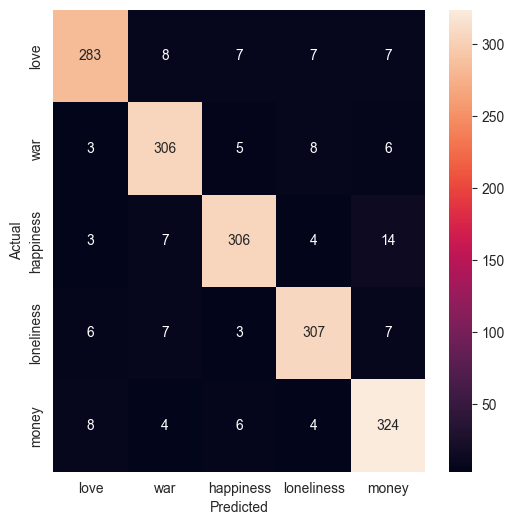

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['love', 'war', 'happiness', 'loneliness', 'money'], yticklabels=['love', 'war', 'happiness', 'loneliness', 'money'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Проверим производительность модели по всему набору данных, разбив весь датасет на (train, test) 5 различными способами (https://stephenallwright.com/cross_val_score-sklearn/)

In [32]:
from sklearn.model_selection import cross_val_score

accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=5)
accuracies

array([0.921, 0.927, 0.922, 0.923, 0.928])

Отчет по классификации для каждого класса. Столбец support - количество песен из указанной категории в тестовой выборке

In [33]:
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred, target_names=['love', 'war', 'happiness', 'loneliness', 'money']))

              precision    recall  f1-score   support

        love       0.93      0.91      0.92       312
         war       0.92      0.93      0.93       328
   happiness       0.94      0.92      0.93       334
  loneliness       0.93      0.93      0.93       330
       money       0.91      0.94      0.92       346

    accuracy                           0.92      1650
   macro avg       0.93      0.92      0.92      1650
weighted avg       0.93      0.92      0.92      1650



С помощью полученной модели получим предсказание категории для остальных 50 песен, у которых на основании предыдущего анализа частотности слов ни один из 5 заданных жанров не оказался выраженным

In [34]:
features_unclassed.shape

(50, 16994)

50 текстов представлены фичами из различных униграмм и биграмм, полученных выше из общего датасета.

Строим для них предсказания с помощью натренированной модели

In [35]:
y_pred_unlassed = model.predict(features_unclassed)
print(y_pred_unlassed)

[4 4 2 2 2 1 3 0 2 0 3 3 0 1 2 2 2 0 3 2 4 2 3 1 2 1 0 0 1 1 1 1 0 0 1 2 0
 1 3 2 3 0 3 3 2 3 3 3 2 0]


И, наконец

In [36]:
df_unclassed['class'] = y_pred_unlassed
df_res = df_unclassed[['play_count', 'artist', 'title', 'text', 'class']]
df_res['class'] = df_res['class'].replace([0, 1, 2, 3, 4], ['love', 'war', 'happiness', 'loneliness', 'money'])
df_res.reset_index(drop=True, inplace=True)
df_res

/var/folders/qt/7hmdvpc92k32ffm5qkp9k79m0000gn/T/ipykernel_1761/391018258.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res['class'] = df_res['class'].replace([0, 1, 2, 3, 4], ['love', 'war', 'happiness', 'loneliness', 'money'])


,play_count,artist,title,text,class
0,292642,OneRepublic,Secrets,like like time time time time come get get see...,money
1,274627,Five Iron Frenzy,Canada,like come go go go go go oh oh oh oh oh get go...,money
2,209212,Train,Hey_ Soul Sister,love know know know like like time one one one...,happiness
3,192884,Angels and Airwaves,The Gift,know know know know know know know like like l...,happiness
4,130116,Pavement,Mercy:The Laundromat,back eye long wait wait wait home insid line l...,happiness
5,115134,Sheena Easton,Strut (1993 Digital Remaster),like like like like like come come come come c...,war
6,114362,Coldplay,Clocks,know come come come go go go go go oh oh never...,loneliness
7,110240,La Roux,Bulletproof,love time time time time time time time time t...,love
8,99137,Beastie Boys,Unite (2009 Digital Remaster),know know know know like like like like like t...,happiness
9,98667,Metallica,Master Of Puppets,come come come see see see see see see never w...,love


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

ДАЛЬШЕ ИДЕТ МУТЬ, КОТОРУЮ НУЖНО ВЫБОРОЧНО УДАЛИТЬ, НО УЖЕ НЕ СООБРАЖАЕТ ГОЛОВА И НЕТ СИЛ. (((

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


BASELINE

Создадим временный датафрейм из df_mxm_text_songs и df_tag_artist_title

In [ ]:
df_t1 = df_mxm_text_songs.merge(df_tag_artist_title, on='track_id', how='inner')
df_t1.info()

Добавим столбец, объединяющий название песни и ее текст

In [ ]:
df_t1['title_and_text'] = df_t1['title_pure'] + ' ' + df_t1['text']

Составляем мешок слов из содержимого столбца

In [49]:
bow = list(set((' '.join(df_t1['title_and_text'].to_list())).split(' ')))
len(bow)

TypeError: sequence item 13719: expected str instance, float found

Заменяем в столбце с текстами песен Nan на '', затем составляем из всех текстов мешок слов и сохраняем его в файл 'data/bow.txt'

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

df_temp = df_mxm_text_songs['text'].fillna('')
df_temp.head()

0    like like de got would seem someon understand ...
1    know know know know know time time time la la ...
2    love love love love love love love love love l...
3    know got got got feel let would would would ey...
4    like take would wo someth stay burn burn burn ...
Name: text, dtype: object

In [36]:
bow = list(set((' '.join(df_temp.to_list())).split(' ')))
len(bow)

4885

In [99]:
categories = ['love', 'war', 'money', 'happiness', 'loneliness']
categories_stem = stemline(' '.join(categories)).split()

In [100]:
categories_stem

['love', 'war', 'money', 'happi', 'loneli']

In [41]:
df_3.to_csv('data/df_3.csv', index=False)

In [42]:
collections_baseline('love')


,artist,title,play_count
0,Dwight Yoakam,You're The One,726885
1,Tub Ring,Invalid,268353
2,Sam Cooke,Ain't Misbehavin,244730
3,Train,Hey_ Soul Sister,209212
4,Train,Marry Me,174080
5,Lil Wayne / Eminem,Drop The World,155717
6,Bill Withers,Make Love To Your Mind,146978
7,Randy Crawford,Almaz,129868
8,Coldplay,The Scientist,128837
9,Travie McCoy,Billionaire [feat. Bruno Mars] (Explicit Albu...,122318


In [43]:
collections_baseline('war')

,artist,title,play_count
0,Sheena Easton,Strut (1993 Digital Remaster),115134
1,Cradle Of Filth,Better To Reign In Hell,88075
2,Eagles,Hotel California,65585
3,Reality Check,Masquerade (Reality Check Album Version),48393
4,Eminem / Nate Dogg,'Till I Collapse,44305
5,Britney Spears,Toxic,42692
6,Gang Starr/Inspectah Deck,Above The Clouds (Edited),39140
7,Enigma,Knocking On Forbidden Doors,38132
8,Creedence Clearwater Revival,Fortunate Son,34506
9,O.G.C.,Gunn Clapp,33897


In [44]:
collections_baseline('happiness')

Sorry, no such word happiness in song's texts. Try another one.


""


WORD2VEC

In [45]:
df_3_3 = df_3[df_3.text != '']
df_3_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125582 entries, 0 to 384532
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   song_id         125582 non-null  object 
 1   play_count      125582 non-null  int64  
 2   track_id        125582 non-null  object 
 3   artist          125582 non-null  object 
 4   title           125581 non-null  object 
 5   mxm_track_id    125582 non-null  float64
 6   text            125582 non-null  object 
 7   majority_genre  75932 non-null   object 
 8   minority_genre  23984 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 9.6+ MB


In [46]:
songs_texts = [text_song.split() for text_song in df_3_3['text'].values]
len(songs_texts)

125582

In [47]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(songs_texts, vector_size=4000, workers=6)

In [48]:
w2v_model.wv.most_similar(positive='love', topn=2)

[('know', 0.7617577910423279), ('time', 0.7049841284751892)]

In [49]:
res = collections_baseline_('know')
res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   artist      50 non-null     object
 1   title       50 non-null     object
 2   play_count  50 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.3+ KB


In [50]:
collections_baseline('time')

,artist,title,play_count
0,OneRepublic,Secrets,292642
1,Tub Ring,Invalid,268353
2,Train,Hey_ Soul Sister,209212
3,Angels and Airwaves,The Gift,192884
4,Lil Wayne / Eminem,Drop The World,155717
5,Bill Withers,Make Love To Your Mind,146978
6,Travie McCoy,Billionaire [feat. Bruno Mars] (Explicit Albu...,122318
7,La Roux,Bulletproof,110240
8,Beastie Boys,Unite (2009 Digital Remaster),99137
9,Panic At The Disco,Behind The Sea [Live In Chicago],89974


In [51]:
w2v_model.wv.most_similar(positive='war', topn=2)

[('death', 0.6788040399551392), ('hell', 0.6599786281585693)]

In [52]:
collections_baseline_('death')

,artist,title,play_count
0,Metallica,Master Of Puppets,98667
1,The Postal Service,Such Great Heights,58059
2,Eminem / Nate Dogg,'Till I Collapse,44305
3,Five Finger Death Punch,Bad Company,42348
4,Dr. Dre / Eminem,Forgot About Dre,24502
5,Aesop Rock,None Shall Pass (Main),19168
6,Daft Punk,Aerodynamic (Daft Punk Remix),18654
7,Jason Mraz,The Remedy (I Won't Worry) (New EQ'd LP Version),17780
8,Amon Amarth,North Sea Storm (Live),17382
9,Modest Mouse,The World At Large,16256


In [53]:
collections_baseline_('hell')

,artist,title,play_count
0,Train,Marry Me,174080
1,Radiohead,Creep (Explicit),98854
2,Metallica,Master Of Puppets,98667
3,Taylor Swift,Love Story,89589
4,Cradle Of Filth,Better To Reign In Hell,88075
5,Eagles,Hotel California,65585
6,Eminem / Nate Dogg,'Till I Collapse,44305
7,Sheryl Crow,Picture,42563
8,Death Cab for Cutie,I Will Follow You into the Dark (Album Version),39465
9,Gang Starr/Inspectah Deck,Above The Clouds (Edited),39140


In [54]:
w2v_model.wv.most_similar(positive='money', topn=2)

[('game', 0.6866568326950073), ('beat', 0.6707655787467957)]

In [55]:
collections_baseline('money')

,artist,title,play_count
0,Beastie Boys,Unite (2009 Digital Remaster),99137
1,The Verve,Bitter Sweet Symphony,76893
2,Eminem,Mockingbird,74103
3,M.I.A.,Paper Planes,50763
4,Eminem / Nate Dogg,'Till I Collapse,44305
5,Chiddy Bang,Opposite Of Adults,34504
6,Kix,Girl Money,30503
7,Eminem / Dr. Dre / 50 Cent,Crack A Bottle,24856
8,Toby Keith,American Soldier,23872
9,Black Eyed Peas,My Humps,23151


In [56]:
collections_baseline('game')

,artist,title,play_count
0,Dwight Yoakam,You're The One,726885
1,Train,Hey_ Soul Sister,209212
2,Lil Wayne / Eminem,Drop The World,155717
3,Sheena Easton,Strut (1993 Digital Remaster),115134
4,John Mayer,Heartbreak Warfare,87745
5,Guns N' Roses,Paradise City,60787
6,Postal Service,Nothing Better (Album),51280
7,M.I.A.,Paper Planes,50763
8,Reality Check,Masquerade (Reality Check Album Version),48393
9,Eminem / Dina Rae,Superman,45328


In [57]:
collections_baseline('beat')

,artist,title,play_count
0,Train,Hey_ Soul Sister,209212
1,Beastie Boys,Unite (2009 Digital Remaster),99137
2,Florence + The Machine,Cosmic Love,94002
3,Guns N' Roses,Paradise City,60787
4,The Postal Service,Such Great Heights,58059
5,Eminem / Nate Dogg,'Till I Collapse,44305
6,Jack Johnson,Do You Remember,43280
7,Metric,Help I'm Alive,42230
8,O.G.C.,Gunn Clapp,33897
9,Jack Johnson,Breakdown,32684


CLASSIFICATION

In [58]:
collections_baseline('like')

,artist,title,play_count
0,OneRepublic,Secrets,292642
1,Five Iron Frenzy,Canada,274627
2,Tub Ring,Invalid,268353
3,Sam Cooke,Ain't Misbehavin,244730
4,Train,Hey_ Soul Sister,209212
5,Angels and Airwaves,The Gift,192884
6,Train,Marry Me,174080
7,Lil Wayne / Eminem,Drop The World,155717
8,Bill Withers,Make Love To Your Mind,146978
9,Travie McCoy,Billionaire [feat. Bruno Mars] (Explicit Albu...,122318


In [59]:
collections_baseline('know')

,artist,title,play_count
0,Dwight Yoakam,You're The One,726885
1,Sam Cooke,Ain't Misbehavin,244730
2,Train,Hey_ Soul Sister,209212
3,Angels and Airwaves,The Gift,192884
4,Lil Wayne / Eminem,Drop The World,155717
5,Bill Withers,Make Love To Your Mind,146978
6,Coldplay,The Scientist,128837
7,Travie McCoy,Billionaire [feat. Bruno Mars] (Explicit Albu...,122318
8,Coldplay,Clocks,114362
9,Lady GaGa,Alejandro,111615


In [60]:
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

dict = corpora.Dictionary(songs_texts)
dict

In [61]:
corpus = [dict.doc2bow(text) for text in songs_texts]
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 3),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 3),
  (12, 6),
  (13, 1),
  (14, 1),
  (15, 3),
  (16, 5),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 3),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 2),
  (26, 6),
  (27, 1),
  (28, 9),
  (29, 31),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 3),
  (35, 1),
  (36, 2),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 2),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1)],
 [(11, 1),
  (17, 3),
  (28, 4),
  (39, 2),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 4),
  (53, 1),
  (54, 16),
  (55, 1),
  (56, 7),
  (57, 7),
  (58, 3),
  (59, 1),
  (60, 1),
  (61, 3),
  (62, 2),
  (63, 1)],
 [(6, 1),
  (9, 4),
  (34, 1),
  (36, 1),
  (38, 1),
  (40, 5),
  (51, 8),
  (52, 1),
  (64, 1),
  (65, 1),
  (66, 5),
  (67, 10),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 4),
  (78, 1),
  (79,

In [62]:
[[(dict[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('ago', 1),
  ('alon', 1),
  ('apart', 1),
  ('arm', 1),
  ('back', 1),
  ('beg', 1),
  ('blame', 1),
  ('blue', 3),
  ('call', 1),
  ('care', 1),
  ('charm', 1),
  ('cri', 3),
  ('feel', 6),
  ('game', 1),
  ('gone', 1),
  ('goodby', 3),
  ('happen', 5),
  ('hard', 1),
  ('heart', 1),
  ('know', 1),
  ('laugh', 3),
  ('left', 1),
  ('live', 1),
  ('long', 1),
  ('longer', 1),
  ('love', 2),
  ('made', 6),
  ('met', 1),
  ('oh', 9),
  ('one', 31),
  ('open', 1),
  ('play', 1),
  ('real', 1),
  ('reckless', 1),
  ('said', 3),
  ('say', 1),
  ('see', 2),
  ('seem', 1),
  ('shame', 1),
  ('share', 1),
  ('tell', 1),
  ('think', 2),
  ('tore', 1),
  ('well', 1),
  ('within', 1),
  ('yeah', 1),
  ('yet', 1)]]

In [63]:
import gensim

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
										   id2word=dict,
										   num_topics=2,
										   random_state=100,
										   update_every=1,
										   chunksize=100,
										   passes=10,
										   alpha='auto',
										   per_word_topics=True)

In [64]:
lda_model.print_topics()

[(0,
  '0.030*"la" + 0.029*"de" + 0.028*"que" + 0.016*"en" + 0.013*"un" + 0.012*"el" + 0.012*"tu" + 0.011*"se" + 0.011*"mi" + 0.011*"te"'),
 (1,
  '0.014*"love" + 0.013*"know" + 0.010*"like" + 0.009*"get" + 0.009*"time" + 0.008*"go" + 0.008*"one" + 0.008*"got" + 0.008*"come" + 0.007*"oh"')]

In [65]:
# import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
%matplotlib inline

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dict)
vis

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documenta

PreparedData(topic_coordinates=             x    y  topics  cluster       Freq
topic                                          
1      0.31521  0.0       1        1  83.309801
0     -0.31521  0.0       2        1  16.690199, topic_info=       Term           Freq          Total Category  logprob  loglift
1336     la   67221.000000   67221.000000  Default  30.0000  30.0000
1697     de   65265.000000   65265.000000  Default  29.0000  29.0000
342     que   61847.000000   61847.000000  Default  28.0000  28.0000
658      en   35206.000000   35206.000000  Default  27.0000  27.0000
2131     un   28819.000000   28819.000000  Default  26.0000  26.0000
2105     el   27303.000000   27303.000000  Default  25.0000  25.0000
1887     tu   26630.000000   26630.000000  Default  24.0000  24.0000
1875     se   24492.000000   24492.000000  Default  23.0000  23.0000
2114     mi   24309.000000   24309.000000  Default  22.0000  22.0000
346      te   24089.000000   24089.000000  Default  21.0000  21.0000
2432     du   20978.000000   20978.000000  Default  20.0000  20.0000
326       e   21088.000000   21088.000000  Default  19.0000  19.0000
1852     es   19651.000000   19651.000000  Default  18.0000  18.0000
1877     si   18866.000000   18866.000000  Default  17.0000  17.0000
721      le   18534.000000   18534.000000  Default  16.0000  16.0000
2340    ich   16982.000000   16982.000000  Default  15.0000  15.0000
25     love  156963.000000  156963.000000  Default  14.0000  14.0000
1857     je   15747.000000   15747.000000  Default  13.0000  13.0000
353     die   41529.000000   41529.000000  Default  12.0000  12.0000
2222     na   14784.000000   14784.000000  Default  11.0000  11.0000
19     know  142923.000000  142923.000000  Default  10.0000  10.0000
2248    con   14404.000000   14404.000000  Default   9.0000   9.0000
1439     yo   20882.000000   20882.000000  Default   8.0000   8.0000
2827    und   13447.000000   13447.000000  Default   7.0000   7.0000
2180     di   12698.000000   12698.000000  Default   6.0000   6.0000
2634    por   12633.000000   12633.000000  Default   5.0000   5.0000
2112     lo   12548.000000   12548.000000  Default   4.0000   4.0000
1835     et   12304.000000   12304.000000  Default   3.0000   3.0000
3417    che   12203.000000   12203.000000  Default   2.0000   2.0000
1859    les   12091.000000   12091.000000  Default   1.0000   1.0000
19     know  142922.568753  142923.106174   Topic1  -4.3627   0.1826
25     love  156962.382329  156963.005031   Topic1  -4.2690   0.1826
99     like  116853.354873  116853.873333   Topic1  -4.5641   0.1826
87      get  101620.282743  101620.795939   Topic1  -4.7038   0.1826
125    time  100029.372308  100029.913552   Topic1  -4.7196   0.1826
91      got   88552.899370   88553.416595   Topic1  -4.8414   0.1826
29      one   90122.533325   90123.061594   Topic1  -4.8239   0.1826
36      see   80896.651386   80897.173263   Topic1  -4.9319   0.1826
96      let   79588.748431   79589.266842   Topic1  -4.9482   0.1826
196   never   78968.288869   78968.803727   Topic1  -4.9560   0.1826
194    make   68999.777339   69000.286617   Topic1  -5.0909   0.1826
35      say   69102.608438   69103.119771   Topic1  -5.0894   0.1826
12     feel   70180.334763   70180.855190   Topic1  -5.0740   0.1826
163    take   71125.477384   71126.005747   Topic1  -5.0606   0.1826
63      way   67651.086629   67651.597365   Topic1  -5.1107   0.1826
219   would   61985.886875   61986.400494   Topic1  -5.1981   0.1826
141      go   92615.693957   92616.461826   Topic1  -4.7966   0.1826
352     day   58587.603668   58588.117610   Topic1  -5.2545   0.1826
97     life   58505.009771   58505.524197   Topic1  -5.2559   0.1826
4      back   57610.342649   57610.857756   Topic1  -5.2713   0.1826
127    want   75207.532565   75208.220967   Topic1  -5.0048   0.1826
67     away   56473.978052   56474.506357   Topic1  -5.2912   0.1826
18    heart   50555.852440   50556.365046   Topic1  -5.4020   0.1826
101    need   49587.955370   49588.4663

In [66]:
collections_baseline('know', 30)

,artist,title,play_count
0,Scouting for Girls,She's So Lovely,8077
1,LeAnn Rimes,Can't Fight The Moonlight (Theme From 'Coyote ...,7356
2,Lighthouse Family,Ain't No Sunshine,3129
3,The Cars,Tonight She Comes (LP Version),2936
4,N.E.R.D.,You Know What,2264
5,Mos Def / Slick Rick,Auditorium,2173
6,Ryan Adams,Everybody Knows,1808
7,Amy Adams,That's How You Know,1654
8,Keke Palmer,How Will I Know (Album version),1398
9,Kindred the Family Soul,Where Would I Be (The Question),1301


In [67]:
# df_3_3 = df_3[df_3.text != '']
# df_3_3.info()

In [68]:
df_3_3['love'] = 0
df_3_3.loc[(df_3_3['text'].str.count('love') > 10) |
		  ((df_3_3['text'].str.count('love') > 5) &
			(df_3_3['text'].str.count('like') > 10)) |
		  ((df_3_3['text'].str.count('love') > 5) &
			(df_3_3['text'].str.count('know') > 10)) |
		  ((df_3_3['text'].str.count('love') > 5) &
			(df_3_3['text'].str.count('time') > 10)), 'love'] = 1

df_3_3.head()

/var/folders/6v/x7g7kcpx6jz1twr2cdvv_z680000gp/T/ipykernel_1539/2401943538.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3_3['love'] = 0


,song_id,play_count,track_id,artist,title,mxm_track_id,text,majority_genre,minority_genre,love
0,SOBONKR12A58A7A7E0,726885,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One,1104550.0,love love know oh oh oh oh oh oh oh oh oh one ...,Country,NaN,0
1,SOAUWYT12A81C206F1,648239,TRGXQES128F42BA5EB,Björk,Undo,1879235.0,oh oh oh oh way give tri tri tri cri hard hard...,Rock,Electronic,0
6,SONYKOW12AB01849C9,292642,TROAQBZ128F9326213,OneRepublic,Secrets,9076039.0,like like time time time time come get get see...,Rock,NaN,0
7,SOPUCYA12A8C13A694,274627,TRFQOSP128F427C2B2,Five Iron Frenzy,Canada,2320738.0,like come go go go go go oh oh oh oh oh get go...,NaN,NaN,0
8,SOUFTBI12AB0183F65,268353,TRIXAZF128F421EE64,Tub Ring,Invalid,1718996.0,love like like time time go one one one one on...,Rock,Metal,0


In [69]:
df_3_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125582 entries, 0 to 384532
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   song_id         125582 non-null  object 
 1   play_count      125582 non-null  int64  
 2   track_id        125582 non-null  object 
 3   artist          125582 non-null  object 
 4   title           125581 non-null  object 
 5   mxm_track_id    125582 non-null  float64
 6   text            125582 non-null  object 
 7   majority_genre  75932 non-null   object 
 8   minority_genre  23984 non-null   object 
 9   love            125582 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 10.5+ MB


In [70]:
Y_df = df_3_3.filter(['love'], axis=1)
X_df = df_3_3.filter(['text'], axis=1)

In [71]:
X_df['text'][0]

'love love know oh oh oh oh oh oh oh oh oh one one one one one one one one one one one one one one one one one one one one one one one one one one one one one one one see see feel feel feel feel feel feel say yeah back heart tell think think live well long said said said call gone cri cri cri alon left play made made made made made made hard care blue blue blue seem real open arm goodby goodby goodby game laugh laugh laugh happen happen happen happen happen apart yet within met blame share shame longer ago beg charm tore reckless'

In [72]:
type(w2v_model.wv['love'])

numpy.ndarray

In [73]:
w2v_model.wv['love']

array([ 0.04841708,  0.08458659, -0.03054111, ..., -0.1396829 ,
       -0.00480588, -0.06174306], dtype=float32)

In [74]:
def song_average(text: str, vect: w2v_model.wv) -> str:
	text_ = text.split(sep=' ')
	text_sp = []
	res = []
	for word in text_:
		# print(word)
		text_sp.append(vect[word])
	# print(text_sp, len(text_sp))
	# print(len(text_sp))
	res = np.average(text_sp, axis=0)
	# print(len(res))
	# bb = [a for b in res for a in b]
	# return bb
	return ' '.join(map(str, res))

In [75]:
aa = song_average((X_df['text'][0]), w2v_model.wv)
aa

'0.08941209 -0.06660018 -0.0676942 0.006645399 0.11352603 0.01040732 -0.13433492 0.004733249 0.16281101 -0.16932702 -0.108048 0.21246639 -0.073245354 -0.09471768 -0.053755585 -0.0694483 0.309864 0.03376651 0.106424466 0.10885824 -0.014242673 -0.11432572 -0.07538641 0.034073897 -0.057851613 0.11200176 0.11119895 0.021361899 0.027216526 0.106157206 0.108731374 -0.10567301 0.15137257 0.2331437 -0.035856005 0.16212273 -0.07472547 0.089878686 0.01089496 -0.1353773 0.09817762 -0.004873817 0.14832842 0.049003363 -0.0119051505 -0.087594524 0.08255392 -0.13342686 -0.08713891 0.20436813 -0.006948513 0.17084244 -0.13616136 0.053600732 0.16340078 0.035865277 0.11035453 0.14608514 0.08618275 0.10353865 -0.13056263 0.094837725 0.021344138 0.023150876 0.040590324 0.08863549 0.04302754 -0.013017033 0.0627294 0.04054555 -0.028848495 0.096366115 -0.081145875 0.00070649607 0.12695543 0.06679974 0.02303773 0.04615698 0.035460904 -0.068486415 -0.12614568 -0.1590242 -0.06558835 -0.036306877 0.14263354 0.005

In [76]:
str(aa)

'0.08941209 -0.06660018 -0.0676942 0.006645399 0.11352603 0.01040732 -0.13433492 0.004733249 0.16281101 -0.16932702 -0.108048 0.21246639 -0.073245354 -0.09471768 -0.053755585 -0.0694483 0.309864 0.03376651 0.106424466 0.10885824 -0.014242673 -0.11432572 -0.07538641 0.034073897 -0.057851613 0.11200176 0.11119895 0.021361899 0.027216526 0.106157206 0.108731374 -0.10567301 0.15137257 0.2331437 -0.035856005 0.16212273 -0.07472547 0.089878686 0.01089496 -0.1353773 0.09817762 -0.004873817 0.14832842 0.049003363 -0.0119051505 -0.087594524 0.08255392 -0.13342686 -0.08713891 0.20436813 -0.006948513 0.17084244 -0.13616136 0.053600732 0.16340078 0.035865277 0.11035453 0.14608514 0.08618275 0.10353865 -0.13056263 0.094837725 0.021344138 0.023150876 0.040590324 0.08863549 0.04302754 -0.013017033 0.0627294 0.04054555 -0.028848495 0.096366115 -0.081145875 0.00070649607 0.12695543 0.06679974 0.02303773 0.04615698 0.035460904 -0.068486415 -0.12614568 -0.1590242 -0.06558835 -0.036306877 0.14263354 0.005

In [77]:
X_df['text_av_2'] = X_df['text'].apply(song_average, args=[w2v_model.wv])
X_df.head()

,text,text_av_2
0,love love know oh oh oh oh oh oh oh oh oh one ...,0.08941209 -0.06660018 -0.0676942 0.006645399 ...
1,oh oh oh oh way give tri tri tri cri hard hard...,0.060092125 0.14389029 0.0217994 -0.03399162 0...
6,like like time time time time come get get see...,0.030598722 -0.07300547 0.017536374 -0.0512327...
7,like come go go go go go oh oh oh oh oh get go...,0.03289878 0.03902449 -0.004848983 0.009482988...
8,love like like time time go one one one one on...,0.006825119 -0.022496315 -0.009095547 0.015536...


In [78]:
len(X_df['text_av_2'][1])

48411

In [79]:
X_df['text_av_2'][1]

'0.060092125 0.14389029 0.0217994 -0.03399162 0.07329148 0.0012076194 -0.023030214 0.07277868 0.023757072 0.0004346842 0.0062103043 -0.055081606 -0.003826899 0.091032326 0.05418856 0.064998016 0.0093016755 -0.026554119 -0.037819568 0.050916094 -0.01068544 0.002991974 0.09316267 0.019887447 0.010126098 0.047082845 0.07827328 0.06354119 -0.054086085 -0.03822539 0.04950115 0.09537631 0.009140565 -0.07373856 -0.057777714 -0.12851304 0.04573239 0.08603539 -0.021507617 -0.08261123 0.0099944 -0.04236327 0.029670648 -0.062003165 0.014152839 0.030977411 0.017615518 -0.020809937 -0.031015033 0.016516626 0.06031945 -0.031894337 0.0977821 -0.10162924 -0.04525512 0.006241334 -0.028683446 -0.009747201 0.02557263 0.034783218 -0.082358114 0.008532849 0.05693953 0.013690006 0.004022627 0.04542164 -0.0009733017 0.025776437 -0.031495254 -0.006347908 -0.034853928 -0.009316113 -0.04433025 0.018279748 -0.13183302 0.0007847971 0.0604601 0.0030460055 0.01700796 -0.0069008376 -0.023487676 -0.004624587 0.049744

In [80]:
X_df_1 = X_df['text_av_2'].str.split(' ', expand=True)
X_df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125582 entries, 0 to 384532
Columns: 4000 entries, 0 to 3999
dtypes: object(4000)
memory usage: 3.7+ GB


In [81]:
Y_df

,love
0,0
1,0
6,0
7,0
8,0
...,...
384521,0
384524,0
384527,0
384529,0


In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_df_1,
													Y_df,
													test_size=0.2,
													random_state=42,
												   )

In [83]:
y_test_onehot = y_test.copy().astype('category')
y_train_onehot = y_train.copy().astype('category')

In [84]:
from feature_engine.encoding import OneHotEncoder as FEOneHotEncoder

ohe = FEOneHotEncoder()
ohe.fit(y_test_onehot)
y_test_onehot = ohe.transform(y_test_onehot)
# y_test_onehot
ohe = FEOneHotEncoder()
ohe.fit(y_train_onehot)
y_train_onehot = ohe.transform(y_train_onehot)
y_train_onehot

,love_0,love_1
219601,1,0
140871,1,0
189056,1,0
115434,1,0
251553,1,0
...,...,...
354227,1,0
280961,1,0
1899,1,0
31554,1,0


In [85]:
# param_grid = {
#         'n_estimators': [20, 300], # 20,
#         'max_features': ['sqrt', 'auto'], # , 'auto'
#         'max_depth': [2, 32], # 2,
#         'criterion': ['entropy', 'gini'] #, 'gini'
#     }

In [86]:
from sklearn.ensemble import RandomForestClassifier

# clf_rf = RandomForestClassifier(random_state=42)

In [87]:
# gs_clf_rf = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, scoring='roc_auc')

In [88]:
# gs_clf_rf.fit(X_train, y_train)

In [89]:
model_rf = RandomForestClassifier(random_state=42,
							n_estimators=100, # 200
							max_features='sqrt', # 'auto'
							max_depth=32, # 10
							criterion='entropy') # None

In [90]:
model_rf.fit(X_train, y_train)

/var/folders/6v/x7g7kcpx6jz1twr2cdvv_z680000gp/T/ipykernel_1539/2300366389.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', max_depth=32, max_features='sqrt',
                       random_state=42)

In [91]:
y_pred_rf = model_rf.predict(X_test)

In [92]:
accuracy_score(y_test, y_pred_rf)

0.9810885057928893

In [93]:
y_pred_proba_rf = model_rf.predict_proba(X_test)

In [94]:
from sklearn.metrics import accuracy_score, roc_auc_score

roc_auc_score(y_test_onehot, y_pred_proba_rf)

0.9725835380139504

In [95]:
lr = LogisticRegression(C=100, penalty='l2', max_iter=200)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [96]:
accuracy_score(y_test, y_pred_lr)

0.9830393757216228

In [97]:
y_pred_proba_lr = lr.predict_proba(X_test)

In [98]:
# from sklearn.metrics import accuracy_score, roc_auc_score

roc_auc_score(y_test_onehot, y_pred_proba_lr)

0.9818155512771776

In [99]:
X_test['pred_love'] = y_pred_lr
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,3991,3992,3993,3994,3995,3996,3997,3998,3999,pred_love
218587,-0.09588778,-0.08854622,-0.024340158,-0.047410484,0.025565937,-0.005671436,0.019175075,-0.030127443,0.06311961,-0.053899005,...,0.03742094,0.06920495,0.044286326,-0.0031478642,-0.0676569,0.02431927,-0.066561185,-0.027199276,-0.012675297,0
118213,-0.05801038,-0.09863833,-0.0353805,-0.06535148,0.031910677,-0.03840278,-0.021065,-0.08002557,0.043765962,0.012926752,...,0.022142457,0.04475126,-0.0015209275,-0.02130397,-0.13786682,0.023918059,-0.022251857,-0.0044361814,-0.013386522,0
287394,-0.03423197,-0.039414264,-0.016991694,0.009805407,-0.0059185135,-0.028807055,0.05192228,-0.05039466,0.079743765,-0.050186723,...,0.06039497,0.0012423553,0.045353603,0.07317889,-0.05922748,0.022081858,-0.012474089,-0.01825889,-0.015196935,0
80735,-0.08702428,-0.15773888,0.032871824,-0.025458358,-0.07943379,-0.062517844,0.11039224,-0.13382192,0.08329254,0.0010490319,...,0.072997116,0.027999638,0.045374148,0.009680871,-0.10446435,0.07542166,0.011922085,-0.031193383,0.026003553,0
208157,-0.16460492,-0.1314499,-0.14744239,-0.059645068,0.05862598,-0.04398625,-0.038938794,-0.22202556,0.038382012,0.003546015,...,0.008533434,0.13014415,0.079066604,0.0017346252,-0.086891554,0.05032463,-0.055410072,-0.058376286,-0.111573674,0


In [100]:
df_rec = X_test[X_test['pred_love'] == 1]
df_rec.head()

,0,1,2,3,4,5,6,7,8,9,...,3991,3992,3993,3994,3995,3996,3997,3998,3999,pred_love
10810,-0.1495284,-0.1481671,-0.054321855,-0.10920901,0.11644073,-0.14061905,-0.0250546,-0.16370639,0.13342878,0.010336215,...,-0.028664684,0.020830428,-0.0087988805,-0.049141593,-0.07609024,0.037993185,-0.13054207,0.03149795,-0.033763163,1
104445,0.00092548353,-0.009316749,0.039395064,-0.0013155323,0.06074825,0.014869636,0.10364458,-0.08367835,0.14091724,-0.12421003,...,0.13151221,0.012689509,0.032521904,0.16786785,-0.13100608,0.0465518,-0.029277112,-0.0049980283,-0.009538579,1
169540,-0.09429142,-0.06334706,-0.029677657,-0.029868742,0.10722534,-0.016552743,-0.05256499,-0.16282187,0.17661345,-0.11562824,...,0.028208662,0.034432966,-0.028944558,0.013408414,-0.13559444,0.032017045,-0.028405696,-0.016255574,-0.006842245,1
332910,-0.12155496,-0.16607982,-0.0078054895,-0.039771035,0.008914355,-0.03143894,0.03528727,-0.16904709,0.109603,-0.02330813,...,0.028417809,-0.0005431362,0.03344141,0.048914846,-0.16105208,0.07795122,-0.0816993,-0.0040615574,0.03898521,1
134194,-0.041908555,-0.06597114,-0.044518016,0.0011835991,0.050904013,-0.09318964,-0.09083757,-0.10882745,0.14990401,-0.045641016,...,0.03737386,-0.019384809,0.023800945,0.009284005,-0.055677637,0.006999019,-0.015895143,0.038567297,-0.03173668,1


In [101]:
df_test = pd.DataFrame.join(df_3_3, df_rec, how='left')
df_test.head()

,song_id,play_count,track_id,artist,title,mxm_track_id,text,majority_genre,minority_genre,love,...,3991,3992,3993,3994,3995,3996,3997,3998,3999,pred_love
0,SOBONKR12A58A7A7E0,726885,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One,1104550.0,love love know oh oh oh oh oh oh oh oh oh one ...,Country,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SOAUWYT12A81C206F1,648239,TRGXQES128F42BA5EB,Björk,Undo,1879235.0,oh oh oh oh way give tri tri tri cri hard hard...,Rock,Electronic,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,SONYKOW12AB01849C9,292642,TROAQBZ128F9326213,OneRepublic,Secrets,9076039.0,like like time time time time come get get see...,Rock,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,SOPUCYA12A8C13A694,274627,TRFQOSP128F427C2B2,Five Iron Frenzy,Canada,2320738.0,like come go go go go go oh oh oh oh oh get go...,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,SOUFTBI12AB0183F65,268353,TRIXAZF128F421EE64,Tub Ring,Invalid,1718996.0,love like like time time go one one one one on...,Rock,Metal,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
index_list = str(df_rec.index.to_list())
index_list

'[10810, 104445, 169540, 332910, 134194, 204648, 200230, 60576, 76916, 214286, 328324, 283223, 333288, 297218, 157149, 134137, 349177, 231995, 100883, 68604, 316460, 115809, 239287, 234355, 40561, 131482, 141580, 199486, 206833, 147043, 28211, 190216, 94226, 41566, 356003, 191920, 340760, 340277, 207759, 24892, 187178, 233433, 142486, 40429, 234775, 152896, 211748, 77367, 92541, 110168, 285408, 224921, 183293, 294409, 375280, 10291, 65571, 203984, 8717, 225216, 185763, 25272, 157599, 261460, 129309, 118558, 58381, 98706, 109291, 26903, 115768, 43322, 185731, 24199, 39944, 173203, 188558, 67037, 71779, 10097, 51436, 281436, 59201, 243654, 59876, 148967, 257950, 13129, 161142, 37122, 129472, 163164, 4972, 300587, 332841, 61127, 352573, 22593, 70389, 49519, 102782, 50123, 176555, 181109, 12407, 5795, 43317, 64468, 255762, 117059, 35544, 156281, 186264, 305664, 172499, 192655, 223288, 9486, 235617, 145940, 157529, 290588, 38721, 369423, 112251, 211417, 78565, 49130, 274532, 230786, 261463,

In [103]:
df_test = df_3.iloc[[index_list]]
df_test.head()

ValueError: invalid literal for int() with base 10: '[10810, 104445, 169540, 332910, 134194, 204648, 200230, 60576, 76916, 214286, 328324, 283223, 333288, 297218, 157149, 134137, 349177, 231995, 100883, 68604, 316460, 115809, 239287, 234355, 40561, 131

In [ ]:
df_3_3.info()

## People similar to you listen


		1. Использовать разбиение на train/test вырезанием sub-matrix из user-item matrix (?)
		2. Использовать метрику p@k (точность при k) - процент правильных рекомендаций
		3. Скрипт должен вернуть 10 рекомендаций для данного пользователя со след. полями:
			1. порядковый номер
			2. имя исполнителя
			3. название трека
		4. Таблица должна быть отсортирована по убыванию вероятности того, что трек «понравится» тому или иному пользователю.

In [15]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

df_4 = pd.merge(df_echonest, df_track.drop_duplicates(subset='song_id', keep='first'), on='song_id', how='inner')
df_4.head()

,user_id,song_id,play_count,track_id,artist,title,mxm_track_id,text,majority_genre,minority_genre
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove,NaN,NaN,Rock,Folk
1,7c86176941718984fed11b7c0674ff04c029b480,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove,NaN,NaN,Rock,Folk
2,76235885b32c4e8c82760c340dc54f9b608d7d7e,SOAKIMP12A8C130995,3,TRIQAUQ128F42435AD,Jack Johnson,The Cove,NaN,NaN,Rock,Folk
3,250c0fa2a77bc6695046e7c47882ecd85c42d748,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove,NaN,NaN,Rock,Folk
4,3f73f44560e822344b0fb7c6b463869743eb9860,SOAKIMP12A8C130995,6,TRIQAUQ128F42435AD,Jack Johnson,The Cove,NaN,NaN,Rock,Folk


In [16]:
df_4 = df_4[['user_id', 'song_id', 'play_count', 'artist', 'title']]
df_4.head()

,user_id,song_id,play_count,artist,title
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,Jack Johnson,The Cove
1,7c86176941718984fed11b7c0674ff04c029b480,SOAKIMP12A8C130995,1,Jack Johnson,The Cove
2,76235885b32c4e8c82760c340dc54f9b608d7d7e,SOAKIMP12A8C130995,3,Jack Johnson,The Cove
3,250c0fa2a77bc6695046e7c47882ecd85c42d748,SOAKIMP12A8C130995,1,Jack Johnson,The Cove
4,3f73f44560e822344b0fb7c6b463869743eb9860,SOAKIMP12A8C130995,6,Jack Johnson,The Cove


In [17]:
df_4.to_csv('data/df_4.csv', index=False)

In [19]:
df_4_ = pd.read_csv('data/df_4.csv')

In [20]:
df_4_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48373531 entries, 0 to 48373530
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   user_id     object
 1   song_id     object
 2   play_count  int64 
 3   artist      object
 4   title       object
dtypes: int64(1), object(4)
memory usage: 1.8+ GB


In [107]:
# df_4['user_id'].unique()
aa = len(df_4['user_id'].unique())

In [108]:
aa

1019318

In [109]:
bb =df_4['song_id'].unique()

In [21]:
U = len(df_4_['user_id'].unique())
S = len(df_4_['song_id'].unique())

u_m = {}
uid = np.unique(df_4_['user_id'])
nums_U = list(range(U))
for u, n in zip(uid, nums_U):
	u_m[u] = n

s_m = {}
sid = np.unique(df_4_['song_id'])
nums_S = list(range(S))
for u, n in zip(sid, nums_S):
	s_m[u] = n
# u_m = dict(zip(np.unique(df_4['user_id']), list(range(aa))))

In [22]:
u_ind = [u_m[i] for i in df_4_['user_id']]
s_ind = [s_m[i] for i in df_4_['song_id']]

In [112]:
s_m['SOAKIMP12A8C130995']

6347

user_mapper (u_m) - словарь uid: порядковый номер
song_mapper (s_m) - словарь sid: порядковый номер
user_inv_mapper - словарь порядковый номер: словарь uid
song_inv_mapper  - словарь порядковый номер: словарь sid
user_index (u_ind)- [индекс user-а по uid в основной базе колонки 'user_id']
song_index (s_ind) - [индекс song по sid в основной базе колонки 'song_id']
user_matrix (u_mx)- матрица u_ind x s_ind
song_matrix (s_mx) - матрица s_ind x u_ind

In [23]:
u_mx = csr_matrix((df_4_['play_count'], (u_ind, s_ind)), shape=(U, S))
u_mx

<1019318x384539 sparse matrix of type '<class 'numpy.int64'>'
	with 48373531 stored elements in Compressed Sparse Row format>

In [24]:
import scipy

scipy.sparse.save_npz('data/u_mx.npz', u_mx, compressed=True)

In [25]:
u_mx_ = scipy.sparse.load_npz('data/u_mx.npz')
u_mx_

<1019318x384539 sparse matrix of type '<class 'numpy.int64'>'
	with 48373531 stored elements in Compressed Sparse Row format>

In [18]:
df_4_.head()

NameError: name 'df_4_' is not defined

In [26]:
s_mx = csr_matrix((df_4_['play_count'], (s_ind, u_ind)), shape=(S, U))
s_mx

<384539x1019318 sparse matrix of type '<class 'numpy.int64'>'
	with 48373531 stored elements in Compressed Sparse Row format>

In [27]:
scipy.sparse.save_npz('data/s_mx.npz', u_mx, compressed=True)

In [28]:
s_mx_ = scipy.sparse.load_npz('data/s_mx.npz')
s_mx_

<1019318x384539 sparse matrix of type '<class 'numpy.int64'>'
	with 48373531 stored elements in Compressed Sparse Row format>

In [38]:
np.count_nonzero(u_mx_[1, :19000].toarray())

1

In [37]:
np.count_nonzero(u_mx_[0], axis=0)

ValueError: setting an array element with a sequence.

In [46]:
num_users, num_songs = u_mx_l.toarray().shape
num_test_users = int(0.05 * num_users)
num_test_users

203863

In [47]:
num_test_songs = int(0.05 * num_songs)
num_test_songs

76907

In [48]:
np.count_nonzero(u_mx_[1, :80000].toarray())

3

In [44]:
u_mx_l = u_mx_.tolil()

u_mx_l

<1019318x384539 sparse matrix of type '<class 'numpy.int64'>'
	with 193492335 stored elements in List of Lists format>

In [45]:
np.count_nonzero(u_mx_l[1, :72000].toarray())

3

In [49]:
df_4_train = u_mx_l[:num_test_users, :num_test_songs]
# df_4_train[:num_test_users, :num_test_songs] = 0
df_4_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [50]:
np.count_nonzero(df_4_train[1].toarray())

3

In [51]:
np.count_nonzero(u_mx_l[1, :num_test_songs].toarray())

3

In [52]:
u_mx_l[:num_test_users, :num_test_songs] = 0
np.count_nonzero(u_mx_l[1, :num_test_songs].toarray())

0

In [53]:
u_mx_l[:num_test_users, :num_test_songs] * 0

<203863x76907 sparse matrix of type '<class 'numpy.int64'>'
	with 0 stored elements in List of Lists format>

In [63]:
np.count_nonzero(df_4_train[0].toarray())

4

In [55]:
import implicit

# initialize a model
model = implicit.als.AlternatingLeastSquares(factors=64)



In [56]:
# train the model on a sparse matrix of user/item/confidence weights
model.fit(u_mx_l)



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed lil_matrix instead. Converting to CSR took 1.6999411582946777 seconds
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

In [84]:
u_mx_l_csr = u_mx_l.tocsr()
xx = u_mx_l_csr[1]
yy = xx.toarray()
yy[0][67915]

0

In [91]:
# recommend items for a user
recommendations = model.recommend(2, u_mx_l_csr[2])


In [92]:
recommendations

(array([383888, 325386, 249942, 344890, 349387, 380561, 371703, 357633,
        361976, 372223], dtype=int32),
 array([0.00919282, 0.00652596, 0.0065243 , 0.006521  , 0.00644908,
        0.0062789 , 0.00601466, 0.00600644, 0.00586441, 0.00580125],
       dtype=float32))

In [93]:
np.nonzero(df_4_train[2].toarray())

(array([0, 0]), array([26819, 31350]))

In [65]:
u_mx_[0][67915]

IndexError: row index (67915) out of range

In [ ]:

# find related items
related = model.similar_items(itemid)

In [ ]:
row = np.array([0, 0, 1, 2, 2, 2])
col = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])
csr_matrix((data, (row, col)), shape=(6, 6)).toarray()

In [115]:
import numpy as np
from scipy.sparse import csr_matrix

row = np.array([0, 0, 1, 2, 2, 2, 0, 1])
col = np.array([0, 2, 2, 0, 1, 2, 1, 0])
data = np.array([1, 2, 3, 4, 5, 6, 7, 8])
aa = csr_matrix((data, (row, col)), shape=(3, 3))
aa.toarray()

array([[1, 7, 2],
       [8, 0, 3],
       [4, 5, 6]])

In [116]:
dd = aa[:2, :2].copy()
dd.toarray()

array([[1, 7],
       [8, 0]])

array([[0, 7],
       [8, 0]])

In [94]:
from implicit.nearest_neighbours import bm25_weight

# weight the matrix, both to reduce impact of users that have played the same artist thousands of times
# and to reduce the weight given to popular items
songs_users = bm25_weight(s_mx_, K1=100, B=0.8)

# get the transpose since the most of the functions in implicit expect (user, item) sparse matrices instead of (item, user)
user_plays = s_mx_.T.tocsr()

In [95]:
model = implicit.als.AlternatingLeastSquares(factors=64, regularization=0.05, alpha=2.0)
model.fit(user_plays)

  0%|          | 0/15 [00:00<?, ?it/s]

In [96]:
userid = 12345
ids, scores = model.recommend(userid, user_plays[userid], N=10, filter_already_liked_items=False)

In [97]:
pd.DataFrame({"score": scores, "already_liked": np.in1d(ids, user_plays[userid].indices)})

,score,already_liked
0,0.066523,False
1,0.060931,False
2,0.058170,False
3,0.057013,False
4,0.055229,False
5,0.053665,False
6,0.048826,False
7,0.048440,False
8,0.046898,False
9,0.046732,False


In [98]:
userids = np.arange(1000)
ids, scores = model.recommend(userids, user_plays[userids])
ids, ids.shape

(array([[859158, 719893, 422910, ..., 741581, 907407,  43309],
        [422910, 741581, 859158, ..., 252820, 907407, 233208],
        [651448, 940323, 255645, ..., 506151, 304907, 652526],
        ...,
        [859158,  68721,  78762, ..., 296650, 614757, 589870],
        [216600, 252820, 408853, ..., 537427, 340734, 999228],
        [229730, 537427, 102462, ..., 453228, 273154, 459911]], dtype=int32),
 (1000, 10))

In [99]:
num_users, num_songs = user_plays.toarray().shape
num_test_users = int(0.1 * num_users)
num_test_users



38453

In [100]:
num_test_songs = int(0.05 * num_songs)
num_test_songs

50965

In [101]:
 user_plays_l = user_plays.tolil()

In [102]:
user_plays_l[:num_test_users, :num_test_songs] * 0

<38453x50965 sparse matrix of type '<class 'numpy.int64'>'
	with 0 stored elements in List of Lists format>

In [103]:
user_plays_test = user_plays_l.tocsr()

In [107]:
from implicit.evaluation import *

implicit.evaluation.precision_at_k(model, user_plays, user_plays_test, K=10, show_progress=True, num_threads=1)

  0%|          | 0/384539 [00:00<?, ?it/s]

0.0

In [110]:
model_nn_cos = implicit.nearest_neighbours.CosineRecommender(K=10, num_threads=4)

In [111]:
model_nn_cos.fit(user_plays)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.34641003608703613 seconds
  warnings.warn(


  0%|          | 0/1019318 [00:00<?, ?it/s]

In [112]:
userid = 12345
ids1, scores1 = model_nn_cos.recommend(userid, user_plays[userid], N=10, filter_already_liked_items=False)

TypeError: No matching signature found

In [ ]:
pd.DataFrame({"score": scores1, "already_liked": np.in1d(ids1, user_plays[userid].indices)})

In [114]:
user_plays_l1 = user_plays.tolil()
user_plays_t = user_plays_l1[:500]
user_plays_test1 = user_plays_t.tocsr()
user_plays_test1

<500x1019318 sparse matrix of type '<class 'numpy.int64'>'
	with 48519 stored elements in Compressed Sparse Row format>

In [115]:
implicit.evaluation.precision_at_k(model, user_plays, user_plays_test1, K=10, show_progress=True, num_threads=1)

  0%|          | 0/500 [00:00<?, ?it/s]

0.0